In [224]:
import sys
sys.path.insert(1, "../TransformerLens/")

from transformers import AutoImageProcessor, ViTForImageClassification, CLIPVisionModelWithProjection, AutoProcessor
from transformer_lens.HookedViT import HookedViT
from transformer_lens.loading_from_pretrained import convert_vit_weights, convert_clip_weights
import transformer_lens.utils as utils
from jaxtyping import Float
from functools import partial
from transformers import logging
logging.set_verbosity_error()

from PIL import Image
import numpy as np
import torch
import glob
import os
import pickle
import itertools
import shutil
import random
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.contrib import itertools as tqdm_itertools
import tqdm

In [282]:
def load_model(pretrain="imagenet", patch_size=32, compositional=-1):
    '''
    :param pretrain: "scracth", "imagenet", "clip"
    :param patch_size: = 16, 32
    '''
    
    try:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
    except AttributeError:  # if MPS is not available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
        
    if compositional < 0:
        train_str = "256-256-256"
    else:
        train_str = f"{compositional}-{compositional}-{256-compositional}"
    
    if pretrain == "scratch" or pretrain == "imagenet":
        hf_model = ViTForImageClassification.from_pretrained(f"google/vit-base-patch{patch_size}-224-in21k", num_labels=2).to(device)
        tl_model = HookedViT.from_pretrained(f"google/vit-base-patch{patch_size}-224-in21k").to(device)
        image_processor = AutoImageProcessor.from_pretrained(f"google/vit-base-patch{patch_size}-224-in21k")

    elif pretrain == "clip":
        hf_model = CLIPVisionModelWithProjection.from_pretrained(f"openai/clip-vit-base-patch{patch_size}")
        tl_model = HookedViT.from_pretrained(f"openai/clip-vit-base-patch{patch_size}", is_clip=True)
        image_processor = AutoProcessor.from_pretrained(f"openai/clip-vit-base-patch{patch_size}")
        
        in_features = hf_model.visual_projection.in_features
        hf_model.visual_projection = torch.nn.Linear(in_features, 2, bias=False).to("mps")
        tl_model.classifier_head.W = hf_model.visual_projection.weight
        
    model_path = glob.glob(f"models/{pretrain}_vit{patch_size}/{train_str}*.pth")[0]
    model_file = torch.load(model_path, map_location=torch.device(device))
    hf_model.load_state_dict(model_file)
    
    if pretrain == "clip":
        state_dict = convert_clip_weights(hf_model, tl_model.cfg)
    else:
        state_dict = convert_vit_weights(hf_model, tl_model.cfg)
    tl_model.load_state_dict(state_dict, strict=False)
    
    tl_model.eval()
    return image_processor, tl_model

In [349]:
def create_noise_image(o, im, split_channels=True):
    if split_channels:
        mu = [int(o.split("-")[i].split("_")[0].replace("mean", "")) for i in range(1, 4)]
    else:
        mu = int(o.split("-")[-1].split("_")[0].replace("mean", ""))
    sigma = int(o.split("-")[-1].split("_")[1][:-4].replace("var", ""))

    data = im.getdata()

    new_data = []
    for item in data:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            new_data.append(item)
        else:
            if split_channels: 
                noise = np.zeros(3, dtype=np.uint8)
                for i in range(3):
                    noise[i] = np.random.normal(
                        loc=mu[i],
                        scale=sigma,
                        size=(1)
                    ).clip(min=0, max=250).astype(np.uint8)
            else:
                noise = (
                    np.random.normal(loc=mu, scale=sigma, size=(1))
                    .clip(min=0, max=250)
                    .astype(np.uint8)
                )
                noise = np.repeat(noise, 3, axis=0)
            new_data.append(tuple(noise))

    im.putdata(new_data)

def create_particular_stimulus(
    shape_1,
    shape_2,
    texture_1,
    texture_2,
    position_1,
    position_2,
    buffer_factor=8,
    im_size=224,
    patch_size=32,
    split_channels=True
):
    # Shape_1 is an integer
    # Texture_1 is a mean_var pair
    # position_1 is an x, y pair
    coords = np.linspace(
        0, im_size, num=(im_size // patch_size), endpoint=False, dtype=int
    )
    possible_coords = list(itertools.product(coords, repeat=2))

    x_1 = coords[position_1[0]]
    y_1 = coords[position_1[1]]
    idx_1 = possible_coords.index((x_1, y_1))
    x_2 = coords[position_2[0]]
    y_2 = coords[position_2[1]]
    idx_2 = possible_coords.index((x_2, y_2))

    path1 = f"{shape_1}-{texture_1}.png"
    path2 = f"{shape_2}-{texture_2}.png"

    im1 = Image.open(f"stimuli/source/NOISE_RGB/{patch_size}/{path1}").convert("RGB")
    im1 = im1.resize(
        (
            patch_size - (patch_size // buffer_factor),
            patch_size - (patch_size // buffer_factor),
        ),
        Image.NEAREST,
    )

    im2 = Image.open(f"stimuli/source/NOISE_RGB/{patch_size}/{path2}").convert("RGB")
    im2 = im2.resize(
        (
            patch_size - (patch_size // buffer_factor),
            patch_size - (patch_size // buffer_factor),
        ),
        Image.NEAREST,
    )

    # Sample noise
    create_noise_image(path1, im1, split_channels=split_channels)
    create_noise_image(path2, im2, split_channels=split_channels)

    # Create blank image and paste objects
    base = Image.new("RGB", (im_size, im_size), (255, 255, 255))

    box1 = [
        coord + random.randint(0, patch_size // buffer_factor) for coord in [x_1, y_1]
    ]
    base.paste(im1, box=box1)

    box2 = [
        coord + random.randint(0, patch_size // buffer_factor) for coord in [x_2, y_2]
    ]
    base.paste(im2, box=box2)

    return base

def create_subspace_datasets(patch_size=32, mode="val", analysis="texture", split_channels=True, compositional=-1,
                            distractor=False):
    path_elements = ["subspace", f"{analysis}_{patch_size}"]
    stub = "stimuli/"
    num_patch = 224 // patch_size

    if analysis == "shape":
        other_feat_str = "texture"
    else:
        other_feat_str = "shape"
    
    for element in path_elements:
        try:
            os.mkdir(stub + element)
        except FileExistsError:
            pass
        
        stub += element + "/"
    
    if compositional > 0:
        train_str = f"trainsize_6400_{compositional}-{compositional}-{256 - compositional}"
    else:
        train_str = "trainsize_6400_256-256-256"
        
    try:
        os.mkdir(stub + train_str)
    except FileExistsError:
        pass
    
    try:
        os.mkdir(stub + train_str + f"/{mode}")
    except FileExistsError:
        pass
    
    all_ims = glob.glob(f"stimuli/source/NOISE_RGB/{patch_size}/*.png")
    all_ims = [im.split("/")[-1][:-4].split("-") for im in all_ims]
    all_ims = [[im[0], f"{im[1]}-{im[2]}-{im[3]}"] for im in all_ims]
    shapes = set([im[0] for im in all_ims])
    textures = set([im[1] for im in all_ims])
    feature_dict = {"shape": sorted(list(shapes)), "texture": sorted(list(textures))}
        
    stim_dir = f"stimuli/NOISE_RGB/aligned/N_{patch_size}/{train_str}"
    base_imfiles = glob.glob(f"{stim_dir}/{mode}/different-{analysis}/*.png")
    stim_dict = pickle.load(open(f"{stim_dir}/{mode}/datadict.pkl", "rb"))
    
    for base in base_imfiles:
        im = Image.open(base)
        base_path = os.path.join(*base.split("/")[-3:])
        base_idx = base.split("/")[-1][:-4]
        datadict = {}
        
        base_dir = f"{stub}{train_str}/{mode}/set_{base_idx}"
        
        try:
            os.mkdir(base_dir)
        except FileExistsError:
            pass
        
        same_stim = stim_dict[f"{mode}/same/{base_idx}.png"]
        diff_stim = stim_dict[base_path]
        datadict["base.png"] = diff_stim.copy()
        datadict["same.png"] = same_stim.copy()
        
        try:
            datadict["base.png"].pop("sd-label")
        except KeyError:
            pass
        
        try:
            datadict["same.png"].pop("sd-label")
        except KeyError:
            pass
        
        shutil.copy(base, f"{base_dir}/base.png")
        shutil.copy(f"{stim_dir}/{mode}/same/{base_idx}.png", f"{base_dir}/same.png")
        
        if same_stim[f"{analysis[0]}1"] != diff_stim[f"{analysis[0]}1"]:  # Which object in the image is the edited one?
            edited_idx = 1
            not_edited_idx = 2
        else:
            edited_idx = 2
            not_edited_idx = 1
            
        # For each texture/shape present in the "different" stimulus, create versions with every shape/texture
        feature0 = diff_stim[f"{analysis[0]}{edited_idx}"]
        feature1 = same_stim[f"{analysis[0]}1"]
        
        for feature, feature_str in zip([feature0, feature1], [f"{analysis}0", f"{analysis}1"]):
            other_idx = 0
            
            for other_feat in feature_dict[other_feat_str]:
                other_1 = diff_stim[f"{other_feat_str[0]}{not_edited_idx}"]
                other_2 = other_feat
                feat_1 = diff_stim[f"{analysis[0]}{not_edited_idx}"]
                feat_2 = feature
                position_1 = diff_stim[f"pos{not_edited_idx}"]
                position_2 = diff_stim[f"pos{edited_idx}"]
                
                if analysis == "texture":
                    dict_str = f"{feature_str}_shape{other_idx}.png"
                else:
                    dict_str = f"{feature_str}_texture{other_idx}.png"
                    
                datadict[dict_str] = {"pos1": position_1, f"{analysis[0]}1": feat_1, f"{other_feat_str[0]}1": other_1,
                                      "pos2": position_2, f"{analysis[0]}2": feat_2, f"{other_feat_str[0]}2": other_2}

                position_1 = [position_1 % num_patch, position_1 // num_patch]
                position_2 = [position_2 % num_patch, position_2 // num_patch]

                if analysis == "texture":
                    im = create_particular_stimulus(other_1, other_2, feat_1, feat_2, position_1, position_2)
                else:
                    im = create_particular_stimulus(feat_1, feat_2, other_1, other_2, position_1, position_2)
                    
                im.save(f"{base_dir}/{dict_str}")
                other_idx += 1
        
        if distractor:
            if analysis == "texture":
                distractor_feats = list(set(textures) - set([feature0, feature1]))
            else:
                distractor_feats = list(set(shapes) - set([feature0, feature1]))

            np.random.shuffle(distractor_feats)
            for d in range(len(distractor_feats)):
                feature = distractor_feats[d]
                #feature = np.random.choice(distractor_feats)
                feature_str = f"{analysis}{d}"

                other_idx = 0

                for other_feat in feature_dict[other_feat_str]:
                    other_1 = diff_stim[f"{other_feat_str[0]}{not_edited_idx}"]
                    other_2 = other_feat
                    feat_1 = diff_stim[f"{analysis[0]}{not_edited_idx}"]
                    feat_2 = feature
                    position_1 = diff_stim[f"pos{not_edited_idx}"]
                    position_2 = diff_stim[f"pos{edited_idx}"]

                    if analysis == "texture":
                        dict_str = f"{feature_str}_shape{other_idx}.png"
                    else:
                        dict_str = f"{feature_str}_texture{other_idx}.png"

                    datadict[dict_str] = {"pos1": position_1, f"{analysis[0]}1": feat_1, f"{other_feat_str[0]}1": other_1,
                                          "pos2": position_2, f"{analysis[0]}2": feat_2, f"{other_feat_str[0]}2": other_2}

                    position_1 = [position_1 % num_patch, position_1 // num_patch]
                    position_2 = [position_2 % num_patch, position_2 // num_patch]

                    if analysis == "texture":
                        im = create_particular_stimulus(other_1, other_2, feat_1, feat_2, position_1, position_2)
                    else:
                        im = create_particular_stimulus(feat_1, feat_2, other_1, other_2, position_1, position_2)

                    im.save(f"{base_dir}/{dict_str}")
                    other_idx += 1
                
        with open(f"{base_dir}/datadict.pkl", "wb") as handle:
            pickle.dump(datadict, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
def create_counting_datasets(patch_size=32, buffer_factor=8, n=-1, k=9, n_per_class=100):
    '''
    :param n: number of unique tasks; by default, max number of unique objects
    :param k: number of objs per im
    '''
    all_ims = glob.glob(f"stimuli/source/NOISE_RGB/{patch_size}/*.png")
    if n < 0:
        n = len(all_ims)
    assert n <= len(all_ims)
    
    num_patch = 224 // patch_size
    assert k <= num_patch**2
    
    coords = np.linspace(
        0, 224, num=(224 // patch_size), endpoint=False, dtype=int
    )
    coords = list(itertools.product(coords, repeat=2))
    
    all_feats = [im.split("/")[-1][:-4].split("-") for im in all_ims]
    all_feats = [[im[0], f"{im[1]}-{im[2]}-{im[3]}"] for im in all_feats]
    all_shapes = set([im[0] for im in all_feats])
    all_textures = set([im[1] for im in all_feats])
    
    object_ims_all = {}
    for o in all_ims:
        o_name = o.split("/")[-1]
        im = Image.open(o).convert("RGB")
        im = im.resize(
            (
                patch_size - (patch_size // buffer_factor),
                patch_size - (patch_size // buffer_factor),
            ),
            Image.NEAREST,
        )
        object_ims_all[o_name] = im
    
    path_elements = ["counting", "NOISE_RGB", f"N_{patch_size}", f"trainsize_{n_per_class}_{n}_{k}"]
    stub = "stimuli/"
    
    for element in path_elements:
        try:
            os.mkdir(stub + element)
        except FileExistsError:
            pass
        
        stub += element + "/"
    
    for mode in ["train", "val", "test"]:
        try:
            os.mkdir(stub + f"/{mode}")
        except FileExistsError:
            pass
        
        for count_class in range(k + 1):
            try:
                os.mkdir(f"{stub}/{mode}/{count_class}")
            except FileExistsError:
                pass
    
    # Choose objects to serve as "task objects" (i.e. objects to count)
    task_ims = np.random.choice(all_ims, size=n)
    
    for mode in ["train", "val", "test"]:
        print(mode)
        im_idxs = {i: 0 for i in range(k + 1)}
        data_dict = {}
        
        for task_idx in range(n):        
            task_obj = task_ims[task_idx].split("/")[-1]
            feats = task_obj.split("-")
            task_obj_shape = feats[0]
            task_obj_texture = f"{feats[1]}-{feats[2]}-{feats[3][:-4]}"
            
            diff_shapes = [d for d in all_shapes if d != task_obj_shape]
            diff_textures = [d for d in all_textures if d != task_obj_texture]

            for count_class in range(k + 1):
                #task_dict[task_idx][f"class_{count_class}"] = {}

                for _ in range(n_per_class):
                    im_idx = im_idxs[count_class]
                    datadict[f"{mode}/{count_class}/{im_idx}.png"] = {}
                    imdict = datadict[f"{mode}/{count_class}/{im_idx}.png"]
                    imdict["task_idx"] = task_idx
                    imdict["task_obj"] = task_obj
                    imdict["task_obj_shape"] = task_obj_shape
                    imdict["task_obj_texture"] = task_obj_texture
                    imdict["count_class"] = count_class
                    
                    if count_class == k:
                        n_same_shape = 0
                        n_same_texture = 0
                        n_diff = 0
                    elif count_class == k - 1:
                        i = np.random.choice(range(3))
                        if i == 0:
                            n_same_shape = 1
                            n_same_texture = 0
                            n_diff = 0
                        elif i == 1:
                            n_same_shape = 0
                            n_same_texture = 1
                            n_diff = 0
                        else:
                            n_same_shape = 0
                            n_same_texture = 0
                            n_diff = 1
                    else:
                        n_same_shape = np.random.choice(range(1, min(k - count_class, 4)))
                        n_same_texture = np.random.choice(range(1, min(k - count_class - n_same_shape + 1, 4)))
                        n_diff = k - count_class - n_same_shape - n_same_texture

                    imdict["all_obj_pos"] = np.random.choice(range(len(coords)), size=k, replace=False)
                    
                    for dictkey in ["all_objs", "all_obj_shapes", "all_obj_textures", "task_obj_pos", 
                             "same_shape_pos", "same_texture_pos", "diff_pos",
                             "task_obj_idx", "same_shape_idx", "same_texture_idx", "diff_idx"]:
                        imdict[dictkey] = []

                    imdict["task_obj_pos"] = imdict["all_obj_pos"][:count_class]
                    imdict["same_shape_pos"] = imdict["all_obj_pos"][count_class:count_class+n_same_shape]
                    imdict["same_texture_pos"] = imdict["all_obj_pos"][count_class+n_same_shape:count_class+n_same_shape+n_same_texture]
                    imdict["diff_pos"] = imdict["all_obj_pos"][count_class+n_same_shape+n_same_texture:]

                    idx = 0
                    for _ in range(count_class):
                        imdict["all_objs"].append(task_obj)
                        imdict["all_obj_shapes"].append(task_obj_shape)
                        imdict["all_obj_textures"].append(task_obj_texture)
                        imdict["task_obj_idx"].append(idx)
                        idx += 1

                    for _ in range(n_same_shape):
                        s = task_obj_shape
                        t = np.random.choice(diff_textures)
                        obj = f"{s}-{t}.png"
                        imdict["all_objs"].append(obj)
                        imdict["all_obj_shapes"].append(s)
                        imdict["all_obj_textures"].append(t)
                        imdict["same_shape_idx"].append(idx)
                        idx += 1

                    for _ in range(n_same_texture):
                        s = np.random.choice(diff_shapes)
                        t = task_obj_texture
                        obj = f"{s}-{t}.png"
                        imdict["all_objs"].append(obj)
                        imdict["all_obj_shapes"].append(s)
                        imdict["all_obj_textures"].append(t)
                        imdict["same_texture_idx"].append(idx)
                        idx += 1

                    for _ in range(n_diff):
                        s = np.random.choice(diff_shapes)
                        t = np.random.choice(diff_textures)
                        obj = f"{s}-{t}.png"
                        imdict["all_objs"].append(obj)
                        imdict["all_obj_shapes"].append(s)
                        imdict["all_obj_textures"].append(t)
                        imdict["diff_idx"].append(idx)
                        idx += 1

                    # Create image
                    base = Image.new("RGB", (224, 224), (255, 255, 255))

                    for o in range(k):
                        obj = imdict["all_objs"][o]
                        im = object_ims_all[obj].copy()
                        create_noise_image(obj, im, split_channels=True)

                        pos = imdict["all_obj_pos"][o]
                        coord = coords[pos]
                        box = [coord[i] + random.randint(0, patch_size // buffer_factor) for i in range(2)]

                        base.paste(im, box=box)

                    base.save(f"{stub}/{mode}/{count_class}/{im_idx}.png", quality=100) 
                    im_idxs[count_class] += 1
            
        with open(f"{stub}/{mode}/datadict.pkl", "wb") as handle:
            pickle.dump(datadict, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
create_counting_datasets(n=10, n_per_class=100, k=5)

train
val
test


In [258]:
def run_exp(set_idx, pretrain="imagenet", mode="texture", patch_size=32, device="mps", random=False,
           distractor=False, distractor_mode="add", data_mode="val", restricted=True, compositional=-1):
    '''
    Runs a single linear subspace experiment (i.e. on a single test set).
    '''
    
    def preprocess(im):
        if pretrain == "clip":
            return image_processor(images=im, return_tensors='pt')["pixel_values"].to(device)
        else:
            return image_processor.preprocess(im, return_tensors="pt")["pixel_values"].to(device)
    
    if random:
        random_str = "_random"
    else:
        random_str = ""
        
    if compositional > 0:
        data_str = f"trainsize_6400_{compositional}-{compositional}-{256 - compositional}"
    else:
        data_str = "trainsize_6400_256-256-256"
    
    num_tokens = (224 // patch_size)**2 + 1
    
    torch.set_grad_enabled(False)
    image_processor, model = load_model(pretrain=pretrain, patch_size=patch_size)
    
    set_dir = f"stimuli/subspace/{mode}_{patch_size}/{data_str}/{data_mode}/set_{set_idx}"
    
    base = preprocess(np.array(Image.open(os.path.join(set_dir, "base.png"))))
    same = preprocess(np.array(Image.open(os.path.join(set_dir, "same.png"))))

    base_logits, base_cache = model.run_with_cache(base, remove_batch_dim=True)
    if base_logits[0, 0] < base_logits[0, 1]:
        return

    same_logits, same_cache = model.run_with_cache(same, remove_batch_dim=True)
    if same_logits[0, 0] > same_logits[0, 1]:
        return
    
    base_logits_diff = base_logits[0, 1] - base_logits[0, 0]
    same_logits_diff = same_logits[0, 1] - same_logits[0, 0]

    # Images containing the original two different textures/shapes
    if distractor and distractor_mode == "subtract":
        base_feat = [np.array(Image.open(b), dtype=np.float32) for b in glob.glob(f"{set_dir}/{mode}2_*.png")]
        distractor_str = f"_{distractor_mode}{distractor}"
    else:
        base_feat = [np.array(Image.open(b), dtype=np.float32) for b in glob.glob(f"{set_dir}/{mode}0_*.png")]
        distractor_str = ""
        
    base_feat = preprocess(base_feat)
    
    # Images containing the same two textures
    if distractor and distractor_mode == "add":
        same_feat = [np.array(Image.open(s), dtype=np.float32) for s in glob.glob(f"{set_dir}/{mode}2_*.png")]
        distractor_str = f"_{distractor_mode}2"
    else:
        same_feat = [np.array(Image.open(s), dtype=np.float32) for s in glob.glob(f"{set_dir}/{mode}1_*.png")]
        distractor_str = ""
        
    same_feat = preprocess(same_feat)

    def get_mean_cache(ims):
        mean_cache = torch.zeros((model.cfg.n_layers, num_tokens, model.cfg.d_model), device=device)
        _, cache = model.run_with_cache(ims)
        
        for layer in range(model.cfg.n_layers):
            activations = cache[utils.get_act_name("resid_post", layer)]
            mean = torch.mean(activations, dim=0)
            mean_cache[layer, :, :] = mean
        
        return mean_cache
    
    same_feat_vecs = get_mean_cache(same_feat)
    base_feat_vecs = get_mean_cache(base_feat)
    
    if random:
        random_feat_vecs = torch.zeros(base_feat_vecs.shape, device=device)
        
        for layer in range(base_feat_vecs.shape[0]):
            for tok in range(base_feat_vecs.shape[1]):
                random_vec = torch.from_numpy(np.random.normal(loc=0, scale=1, size=base_feat_vecs.shape[2]).astype(np.float32)).to(device)
                random_vec /= torch.linalg.norm(random_vec)
                random_vec *= torch.linalg.norm(base_feat_vecs[layer, tok, :])
                random_feat_vecs[layer, tok, :] = random_vec
                
        base2same_feat_vecs = same_feat_vecs - random_feat_vecs
    else:
        base2same_feat_vecs = same_feat_vecs - base_feat_vecs  # Convert base texture to same texture
    
    def patch_fn(
        target_residual_component: Float[torch.Tensor, "batch tok d_model"],
        hook,
        tok,
        diff_vec,
    ):
        target_residual_component[:, tok, :] += diff_vec
        return target_residual_component
    
    logit_diffs = torch.zeros((model.cfg.n_layers, num_tokens), device=device)
    
    if restricted:
        stim_dict = pickle.load(open(os.path.join(set_dir, "datadict.pkl"), "rb"))
        
        if stim_dict["base.png"]["t1"] != stim_dict["same.png"]["t1"]:  # Which object in the image is the edited one?
            edited_pos = stim_dict["base.png"]["pos1"] + 1
            not_edited_pos = stim_dict["base.png"]["pos2"] + 1
        else:
            edited_pos = stim_dict["base.png"]["pos2"] + 1
            not_edited_pos = stim_dict["base.png"]["pos1"] + 1
        
        iterator = tqdm_itertools.product(range(model.cfg.n_layers), [0, edited_pos, not_edited_pos])
        restricted_str = "_restricted"
    else:
        iterator = tqdm_itertools.product(range(model.cfg.n_layers), range(num_tokens))
        restricted_str = ""
    
    for layer, tok in iterator:
        hook_fn = partial(patch_fn, tok=tok, diff_vec=base2same_feat_vecs[layer, tok])
        patched_logits = model.run_with_hooks(
            base,
            fwd_hooks=[(utils.get_act_name("resid_post", layer), hook_fn)],
            return_type="logits",
        )
        patched_logits_diff = patched_logits[0, 1] - patched_logits[0, 0]
        logit_diffs[layer, tok] = 2*(patched_logits_diff - base_logits_diff) / (same_logits_diff - base_logits_diff) - 1

    torch.save(logit_diffs, f"{set_dir}/logit_diffs_{pretrain}{restricted_str}{distractor_str}{random_str}.pt", 
               pickle_protocol=pickle.HIGHEST_PROTOCOL)
    return logit_diffs


def subspace_score(pretrain="imagenet", mode="texture", patch_size=32, sets=None, n=10, device="mps", 
                   plot=True, random=False, distractor=False, distractor_mode="add", data_mode="val",
                   restricted=True, compositional=-1):
    pretrain_label = {"clip": "CLIP-Pretrained", "imagenet": "ImageNet-Pretrained", "scratch": "From Scratch"}
    
    if distractor:
        random = False
        distractor_str = f"_{distractor_mode}2"
    else:
        distractor_str = ""
    
    if random:
        random_str = "_random"
    else:
        random_str = ""
        
    if restricted:
        restricted_str = "_restricted"
    else:
        restricted_str = ""
        
    if compositional > 0:
        data_str = f"trainsize_6400_{compositional}-{compositional}-{256 - compositional}"
    else:
        data_str = "trainsize_6400_256-256-256"
    
    if sets is None:
        existing_sets = [int(i.split("/")[-1].split("_")[-1]) for i in glob.glob(f"stimuli/subspace/{mode}_{patch_size}/{data_str}/{data_mode}/*")]
        sets = np.random.choice(existing_sets, size=min(n, len(existing_sets)))
    elif sets == "all":
        sets = []
        for set_idx in range(3200):
            if os.path.isfile(f"stimuli/subspace/{mode}_{patch_size}/{data_str}/{data_mode}/set_{set_idx}/logit_diffs_{pretrain}{restricted_str}{distractor_str}{random_str}.pt"):
                sets.append(set_idx)

    #print(sets)
    results = {s: {"max_logit_diff": None, "max_logit_diff_idx": None, "logit_diffs": None} for s in sets}
    all_max_logit_diff = []
    all_max_logit_diff_idx = []
    all_logit_diff = []
    all_edited_pos = []
    all_not_edited_pos = []
    
    for set_idx in tqdm.tqdm(sets):
        set_dir = f"stimuli/subspace/{mode}_{patch_size}/{data_str}/{data_mode}/set_{set_idx}"
        stim_dict = pickle.load(open(f"{set_dir}/datadict.pkl", "rb"))
        
        try:
            logit_diffs = torch.load(open(f"{set_dir}/logit_diffs_{pretrain}{restricted_str}{distractor_str}{random_str}.pt", "rb"))
        except FileNotFoundError:
            print(f"Running experiment for set {set_idx}...")
            logit_diffs = run_exp(set_idx, pretrain=pretrain, mode=mode, patch_size=patch_size, device=device, 
                                  random=random, distractor=distractor, distractor_mode="add", data_mode=data_mode, 
                                  restricted=restricted, compositional=compositional)
            
        if logit_diffs is None:
            continue
            
        if stim_dict["base.png"][f"{mode[0]}1"] != stim_dict["same.png"][f"{mode[0]}1"]:  # Which object in the image is the edited one?
            edited_pos = stim_dict["base.png"]["pos1"] + 1
            not_edited_pos = stim_dict["base.png"]["pos2"] + 1
        else:
            edited_pos = stim_dict["base.png"]["pos2"] + 1
            not_edited_pos = stim_dict["base.png"]["pos1"] + 1
            
        all_edited_pos.append(edited_pos)
        all_not_edited_pos.append(not_edited_pos)

        max_idx = torch.argmax(logit_diffs[:, edited_pos])
        max_val = logit_diffs[max_idx, edited_pos]
        
        results[set_idx]["max_logit_diff"] = max_val.item()
        results[set_idx]["max_logit_diff_idx"] = max_idx.item()
        results[set_idx]["logit_diffs"] = logit_diffs.cpu()
        
        all_max_logit_diff.append(max_val.item())
        all_max_logit_diff_idx.append(max_idx.item())
        all_logit_diff.append(logit_diffs.cpu())
    
    print(f"{pretrain_label[pretrain]} ViT-B/{patch_size} subspace score: {np.mean(all_max_logit_diff)} (variance={np.var(all_max_logit_diff)})")

    if plot:
        fig, ax = plt.subplots(2, 2, figsize=(12, 9))
        sns.histplot(data=all_max_logit_diff_idx, stat="count", discrete=True, ax=ax[0][0])
        ax[0][0].set_xticks(range(12))
        ax[0][0].set_title("Model layer where max logit difference occurs across base images")

        sns.histplot(data=all_max_logit_diff, stat="count", bins=40, ax=ax[0][1])
        ax[0][1].set_title("Max logit difference across base images")
        
        all_new_logit_diff = []
        for s in range(len(all_logit_diff)):
            new_logit_diff = torch.zeros((all_logit_diff[0].shape[0], 3))
            new_logit_diff[:, 0] = all_logit_diff[s][:, 0]
            new_logit_diff[:, 1] = torch.select(all_logit_diff[s], 1, all_edited_pos[s])
            new_logit_diff[:, 2] = torch.select(all_logit_diff[s], 1, all_not_edited_pos[s])
            all_new_logit_diff.append(new_logit_diff)
        
        avg_logit_diff = torch.mean(torch.stack(all_new_logit_diff), dim=0)
        var_logit_diff = torch.var(torch.stack(all_new_logit_diff), dim=0)

        #fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
        sns.heatmap(avg_logit_diff, ax=ax[1][0], vmin=-1, vmax=1, xticklabels=["CLS", "Edited Obj", "Non-edited Obj"])
        ax[1][0].set_title("Average logit difference across base images")
        sns.heatmap(var_logit_diff, ax=ax[1][1], vmin=0, vmax=1, xticklabels=["CLS", "Edited Obj", "Non-edited Obj"])
        ax[1][1].set_title("Variance in logit difference across base images")

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Running experiment for set 1780...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  1%|▍                                          | 1/100 [00:08<13:39,  8.28s/it]

Running experiment for set 446...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  2%|▊                                          | 2/100 [00:09<07:06,  4.35s/it]

Running experiment for set 327...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  3%|█▎                                         | 3/100 [00:17<09:35,  5.93s/it]

Running experiment for set 2564...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  4%|█▋                                         | 4/100 [00:25<10:45,  6.73s/it]

Running experiment for set 2002...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  5%|██▏                                        | 5/100 [00:27<07:39,  4.84s/it]

Running experiment for set 2335...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  6%|██▌                                        | 6/100 [00:35<09:17,  5.93s/it]

Running experiment for set 690...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  7%|███                                        | 7/100 [00:36<06:52,  4.44s/it]

Running experiment for set 1542...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  8%|███▍                                       | 8/100 [00:38<05:23,  3.52s/it]

Running experiment for set 3069...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  9%|███▊                                       | 9/100 [00:45<07:15,  4.78s/it]

Running experiment for set 1599...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 10%|████▏                                     | 10/100 [00:53<08:38,  5.76s/it]

Running experiment for set 1200...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 11%|████▌                                     | 11/100 [01:01<09:28,  6.39s/it]

Running experiment for set 1723...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 12%|█████                                     | 12/100 [01:09<10:14,  6.98s/it]

Running experiment for set 497...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 13%|█████▍                                    | 13/100 [01:18<10:41,  7.37s/it]

Running experiment for set 2011...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 14%|█████▉                                    | 14/100 [01:26<11:08,  7.77s/it]

Running experiment for set 2549...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 15%|██████▎                                   | 15/100 [01:35<11:23,  8.05s/it]

Running experiment for set 1711...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 16%|██████▋                                   | 16/100 [01:43<11:11,  7.99s/it]

Running experiment for set 60...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 17%|███████▏                                  | 17/100 [01:45<08:40,  6.27s/it]

Running experiment for set 2689...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 18%|███████▌                                  | 18/100 [01:54<09:37,  7.04s/it]

Running experiment for set 208...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 19%|███████▉                                  | 19/100 [02:03<10:11,  7.55s/it]

Running experiment for set 1985...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 20%|████████▍                                 | 20/100 [02:11<10:19,  7.74s/it]

Running experiment for set 844...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 21%|████████▊                                 | 21/100 [02:18<10:10,  7.73s/it]

Running experiment for set 1441...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 22%|█████████▏                                | 22/100 [02:26<10:05,  7.77s/it]

Running experiment for set 422...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 23%|█████████▋                                | 23/100 [02:34<09:57,  7.76s/it]

Running experiment for set 817...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 24%|██████████                                | 24/100 [02:43<10:15,  8.10s/it]

Running experiment for set 609...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 25%|██████████▌                               | 25/100 [02:51<10:09,  8.13s/it]

Running experiment for set 1192...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 26%|██████████▉                               | 26/100 [02:59<10:00,  8.11s/it]

Running experiment for set 609...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 27%|███████████▎                              | 27/100 [03:08<09:55,  8.16s/it]

Running experiment for set 1702...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 28%|███████████▊                              | 28/100 [03:09<07:25,  6.19s/it]

Running experiment for set 104...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 29%|████████████▏                             | 29/100 [03:10<05:30,  4.66s/it]

Running experiment for set 2876...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 30%|████████████▌                             | 30/100 [03:17<06:21,  5.45s/it]

Running experiment for set 1901...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 31%|█████████████                             | 31/100 [03:19<04:46,  4.15s/it]

Running experiment for set 2350...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 32%|█████████████▍                            | 32/100 [03:20<03:38,  3.21s/it]

Running experiment for set 1411...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 33%|█████████████▊                            | 33/100 [03:29<05:33,  4.97s/it]

Running experiment for set 327...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 34%|██████████████▎                           | 34/100 [03:37<06:31,  5.93s/it]

Running experiment for set 877...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 35%|██████████████▋                           | 35/100 [03:45<07:07,  6.58s/it]

Running experiment for set 1506...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 36%|███████████████                           | 36/100 [03:53<07:24,  6.94s/it]

Running experiment for set 2727...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 37%|███████████████▌                          | 37/100 [04:01<07:36,  7.25s/it]

Running experiment for set 954...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 38%|███████████████▉                          | 38/100 [04:09<07:43,  7.47s/it]

Running experiment for set 461...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 39%|████████████████▍                         | 39/100 [04:17<07:58,  7.85s/it]

Running experiment for set 1732...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 40%|████████████████▊                         | 40/100 [04:26<07:59,  7.99s/it]

Running experiment for set 3143...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 41%|█████████████████▏                        | 41/100 [04:34<07:47,  7.93s/it]

Running experiment for set 90...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 42%|█████████████████▋                        | 42/100 [04:35<05:45,  5.96s/it]

Running experiment for set 2858...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 43%|██████████████████                        | 43/100 [04:36<04:23,  4.62s/it]

Running experiment for set 425...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 44%|██████████████████▍                       | 44/100 [04:45<05:19,  5.70s/it]

Running experiment for set 1646...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 45%|██████████████████▉                       | 45/100 [04:52<05:46,  6.31s/it]

Running experiment for set 797...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 46%|███████████████████▎                      | 46/100 [05:00<06:04,  6.75s/it]

Running experiment for set 2724...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 47%|███████████████████▋                      | 47/100 [05:08<06:16,  7.09s/it]

Running experiment for set 2020...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 48%|████████████████████▏                     | 48/100 [05:16<06:21,  7.34s/it]

Running experiment for set 1536...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 49%|████████████████████▌                     | 49/100 [05:24<06:21,  7.48s/it]

Running experiment for set 2668...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 50%|█████████████████████                     | 50/100 [05:32<06:20,  7.61s/it]

Running experiment for set 1105...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 51%|█████████████████████▍                    | 51/100 [05:33<04:42,  5.76s/it]

Running experiment for set 2733...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 52%|█████████████████████▊                    | 52/100 [05:41<05:08,  6.43s/it]

Running experiment for set 1441...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 53%|██████████████████████▎                   | 53/100 [05:49<05:22,  6.87s/it]

Running experiment for set 909...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 54%|██████████████████████▋                   | 54/100 [05:57<05:30,  7.19s/it]

Running experiment for set 1438...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 55%|███████████████████████                   | 55/100 [06:05<05:29,  7.33s/it]

Running experiment for set 981...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 56%|███████████████████████▌                  | 56/100 [06:13<05:31,  7.53s/it]

Running experiment for set 1022...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 57%|███████████████████████▉                  | 57/100 [06:20<05:24,  7.54s/it]

Running experiment for set 1652...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 58%|████████████████████████▎                 | 58/100 [06:28<05:20,  7.64s/it]

Running experiment for set 2891...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 59%|████████████████████████▊                 | 59/100 [06:36<05:17,  7.75s/it]

Running experiment for set 2561...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 60%|█████████████████████████▏                | 60/100 [06:44<05:13,  7.84s/it]

Running experiment for set 2813...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 61%|█████████████████████████▌                | 61/100 [06:52<05:11,  7.98s/it]

Running experiment for set 473...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 62%|██████████████████████████                | 62/100 [06:54<03:49,  6.05s/it]

Running experiment for set 1931...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 63%|██████████████████████████▍               | 63/100 [07:02<04:08,  6.71s/it]

Running experiment for set 2412...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 64%|██████████████████████████▉               | 64/100 [07:04<03:08,  5.23s/it]

Running experiment for set 434...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 65%|███████████████████████████▎              | 65/100 [07:12<03:29,  5.98s/it]

Running experiment for set 2065...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 66%|███████████████████████████▋              | 66/100 [07:14<02:42,  4.78s/it]

Running experiment for set 2834...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 67%|████████████████████████████▏             | 67/100 [07:22<03:09,  5.74s/it]

Running experiment for set 2534...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 68%|████████████████████████████▌             | 68/100 [07:30<03:28,  6.51s/it]

Running experiment for set 2772...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 69%|████████████████████████████▉             | 69/100 [07:32<02:39,  5.16s/it]

Running experiment for set 2326...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 70%|█████████████████████████████▍            | 70/100 [07:40<03:02,  6.09s/it]

Running experiment for set 1590...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 71%|█████████████████████████████▊            | 71/100 [07:48<03:15,  6.75s/it]

Running experiment for set 2763...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 72%|██████████████████████████████▏           | 72/100 [07:57<03:22,  7.22s/it]

Running experiment for set 2190...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 73%|██████████████████████████████▋           | 73/100 [08:05<03:20,  7.44s/it]

Running experiment for set 621...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 74%|███████████████████████████████           | 74/100 [08:07<02:29,  5.74s/it]

Running experiment for set 2124...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 75%|███████████████████████████████▌          | 75/100 [08:15<02:44,  6.59s/it]

Running experiment for set 788...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 76%|███████████████████████████████▉          | 76/100 [08:23<02:49,  7.07s/it]

Running experiment for set 562...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 77%|████████████████████████████████▎         | 77/100 [08:31<02:49,  7.39s/it]

Running experiment for set 348...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 78%|████████████████████████████████▊         | 78/100 [08:33<02:02,  5.56s/it]

Running experiment for set 1783...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 79%|█████████████████████████████████▏        | 79/100 [08:34<01:29,  4.24s/it]

Running experiment for set 1509...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 80%|█████████████████████████████████▌        | 80/100 [08:36<01:11,  3.58s/it]

Running experiment for set 520...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 81%|██████████████████████████████████        | 81/100 [08:38<00:56,  2.98s/it]

Running experiment for set 3081...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 82%|██████████████████████████████████▍       | 82/100 [08:45<01:19,  4.40s/it]

Running experiment for set 3072...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 83%|██████████████████████████████████▊       | 83/100 [08:53<01:33,  5.52s/it]

Running experiment for set 1108...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 84%|███████████████████████████████████▎      | 84/100 [09:01<01:39,  6.23s/it]

Running experiment for set 704...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 85%|███████████████████████████████████▋      | 85/100 [09:10<01:43,  6.89s/it]

Running experiment for set 384...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 86%|████████████████████████████████████      | 86/100 [09:11<01:14,  5.29s/it]

Running experiment for set 2813...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 87%|████████████████████████████████████▌     | 87/100 [09:19<01:18,  6.02s/it]

Running experiment for set 2210...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 88%|████████████████████████████████████▉     | 88/100 [09:27<01:20,  6.68s/it]

Running experiment for set 3096...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 89%|█████████████████████████████████████▍    | 89/100 [09:35<01:17,  7.08s/it]

Running experiment for set 3152...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 90%|█████████████████████████████████████▊    | 90/100 [09:43<01:13,  7.36s/it]

Running experiment for set 2297...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 91%|██████████████████████████████████████▏   | 91/100 [09:51<01:07,  7.49s/it]

Running experiment for set 2383...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 92%|██████████████████████████████████████▋   | 92/100 [09:59<01:00,  7.61s/it]

Running experiment for set 1123...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 93%|███████████████████████████████████████   | 93/100 [10:07<00:53,  7.66s/it]

Running experiment for set 2932...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 94%|███████████████████████████████████████▍  | 94/100 [10:15<00:46,  7.76s/it]

Running experiment for set 1661...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 95%|███████████████████████████████████████▉  | 95/100 [10:25<00:42,  8.60s/it]

Running experiment for set 167...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 96%|████████████████████████████████████████▎ | 96/100 [10:33<00:33,  8.36s/it]

Running experiment for set 2552...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 97%|████████████████████████████████████████▋ | 97/100 [10:34<00:18,  6.28s/it]

Running experiment for set 850...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████▏| 98/100 [10:42<00:13,  6.77s/it]

Running experiment for set 752...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 99%|█████████████████████████████████████████▌| 99/100 [10:44<00:05,  5.19s/it]

Running experiment for set 1842...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 100/100 [10:52<00:00,  6.52s/it]


From Scratch ViT-B/32 subspace score: 0.9061989752869857 (variance=1.4062647170163955)


  0%|                                                                                                                             | 0/100 [00:00<?, ?it/s]

Running experiment for set 2796...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  1%|█▏                                                                                                                   | 1/100 [00:07<12:44,  7.72s/it]

Running experiment for set 856...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  2%|██▎                                                                                                                  | 2/100 [00:16<13:10,  8.07s/it]

Running experiment for set 99...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  3%|███▌                                                                                                                 | 3/100 [00:24<12:59,  8.04s/it]

Running experiment for set 2920...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  4%|████▋                                                                                                                | 4/100 [00:32<12:51,  8.04s/it]

Running experiment for set 185...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  5%|█████▊                                                                                                               | 5/100 [00:40<12:54,  8.15s/it]

Running experiment for set 2279...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  6%|███████                                                                                                              | 6/100 [00:42<09:21,  5.98s/it]

Running experiment for set 2608...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  7%|████████▏                                                                                                            | 7/100 [00:50<10:17,  6.64s/it]

Running experiment for set 3170...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  8%|█████████▎                                                                                                           | 8/100 [00:51<07:36,  4.96s/it]

Running experiment for set 476...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  9%|██████████▌                                                                                                          | 9/100 [00:59<08:57,  5.91s/it]

Running experiment for set 2326...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 10%|███████████▌                                                                                                        | 10/100 [01:07<09:45,  6.51s/it]

Running experiment for set 2724...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 11%|████████████▊                                                                                                       | 11/100 [01:15<10:18,  6.95s/it]

Running experiment for set 1307...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 12%|█████████████▉                                                                                                      | 12/100 [01:23<10:35,  7.22s/it]

Running experiment for set 3122...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 13%|███████████████                                                                                                     | 13/100 [01:30<10:41,  7.38s/it]

Running experiment for set 1492...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 14%|████████████████▏                                                                                                   | 14/100 [01:32<08:02,  5.61s/it]

Running experiment for set 863...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 15%|█████████████████▍                                                                                                  | 15/100 [01:40<08:51,  6.26s/it]

Running experiment for set 1939...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 16%|██████████████████▌                                                                                                 | 16/100 [01:41<06:51,  4.90s/it]

Running experiment for set 2499...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 17%|███████████████████▋                                                                                                | 17/100 [01:50<08:28,  6.13s/it]

Running experiment for set 1783...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 18%|████████████████████▉                                                                                               | 18/100 [02:00<09:45,  7.14s/it]

Running experiment for set 666...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 19%|██████████████████████                                                                                              | 19/100 [02:09<10:25,  7.72s/it]

Running experiment for set 35...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 20%|███████████████████████▏                                                                                            | 20/100 [02:11<07:48,  5.86s/it]

Running experiment for set 3185...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 21%|████████████████████████▎                                                                                           | 21/100 [02:19<08:37,  6.55s/it]

Running experiment for set 2834...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 22%|█████████████████████████▌                                                                                          | 22/100 [02:26<08:59,  6.91s/it]

Running experiment for set 2017...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 23%|██████████████████████████▋                                                                                         | 23/100 [02:34<09:14,  7.20s/it]

Running experiment for set 1599...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 24%|███████████████████████████▊                                                                                        | 24/100 [02:43<09:34,  7.57s/it]

Running experiment for set 1...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 25%|█████████████████████████████                                                                                       | 25/100 [02:51<09:46,  7.82s/it]

Running experiment for set 202...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 26%|██████████████████████████████▏                                                                                     | 26/100 [03:00<09:50,  7.98s/it]

Running experiment for set 1942...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 27%|███████████████████████████████▎                                                                                    | 27/100 [03:01<07:15,  5.97s/it]

Running experiment for set 1385...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 28%|████████████████████████████████▍                                                                                   | 28/100 [03:09<07:59,  6.66s/it]

Running experiment for set 2531...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 29%|█████████████████████████████████▋                                                                                  | 29/100 [03:10<05:54,  5.00s/it]

Running experiment for set 710...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 30%|██████████████████████████████████▊                                                                                 | 30/100 [03:18<06:57,  5.97s/it]

Running experiment for set 464...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 31%|███████████████████████████████████▉                                                                                | 31/100 [03:26<07:30,  6.52s/it]

Running experiment for set 1186...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 32%|█████████████████████████████████████                                                                               | 32/100 [03:34<07:49,  6.90s/it]

Running experiment for set 1291...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 33%|██████████████████████████████████████▎                                                                             | 33/100 [03:36<05:59,  5.36s/it]

Running experiment for set 685...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 34%|███████████████████████████████████████▍                                                                            | 34/100 [03:44<06:51,  6.24s/it]

Running experiment for set 2683...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 35%|████████████████████████████████████████▌                                                                           | 35/100 [03:52<07:15,  6.69s/it]

Running experiment for set 1010...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████▊                                                                          | 36/100 [04:00<07:40,  7.19s/it]

Running experiment for set 1438...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████▉                                                                         | 37/100 [04:08<07:50,  7.47s/it]

Running experiment for set 30...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████                                                                        | 38/100 [04:16<07:54,  7.65s/it]

Running experiment for set 866...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 39%|█████████████████████████████████████████████▏                                                                      | 39/100 [04:24<07:53,  7.76s/it]

Running experiment for set 2234...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████▍                                                                     | 40/100 [04:32<07:49,  7.82s/it]

Running experiment for set 1474...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 41%|███████████████████████████████████████████████▌                                                                    | 41/100 [04:34<05:50,  5.94s/it]

Running experiment for set 488...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 42%|████████████████████████████████████████████████▋                                                                   | 42/100 [04:42<06:16,  6.49s/it]

Running experiment for set 3096...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 43/100 [04:50<06:35,  6.95s/it]

Running experiment for set 3033...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████                                                                 | 44/100 [04:57<06:43,  7.20s/it]

Running experiment for set 1111...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 45%|████████████████████████████████████████████████████▏                                                               | 45/100 [04:59<04:58,  5.43s/it]

Running experiment for set 1417...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████▎                                                              | 46/100 [05:07<05:35,  6.22s/it]

Running experiment for set 1959...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 47%|██████████████████████████████████████████████████████▌                                                             | 47/100 [05:08<04:10,  4.72s/it]

Running experiment for set 1240...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████▋                                                            | 48/100 [05:16<05:03,  5.84s/it]

Running experiment for set 16...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 49%|████████████████████████████████████████████████████████▊                                                           | 49/100 [05:18<03:53,  4.57s/it]

Running experiment for set 1900...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 50%|██████████████████████████████████████████████████████████                                                          | 50/100 [05:19<02:57,  3.54s/it]

Running experiment for set 906...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 51%|███████████████████████████████████████████████████████████▏                                                        | 51/100 [05:21<02:24,  2.95s/it]

Running experiment for set 387...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 52%|████████████████████████████████████████████████████████████▎                                                       | 52/100 [05:29<03:36,  4.51s/it]

Running experiment for set 1233...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                      | 53/100 [05:37<04:18,  5.50s/it]

Running experiment for set 2908...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                     | 54/100 [05:45<04:54,  6.39s/it]

Running experiment for set 889...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                    | 55/100 [05:53<05:10,  6.91s/it]

Running experiment for set 999...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                   | 56/100 [06:02<05:22,  7.33s/it]

Running experiment for set 1566...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████                                                  | 57/100 [06:10<05:26,  7.59s/it]

Running experiment for set 1771...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████▎                                                | 58/100 [06:18<05:23,  7.70s/it]

Running experiment for set 2053...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                               | 59/100 [06:26<05:15,  7.70s/it]

Running experiment for set 921...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                              | 60/100 [06:33<05:10,  7.75s/it]

Running experiment for set 1960...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 61%|██████████████████████████████████████████████████████████████████████▊                                             | 61/100 [06:35<03:46,  5.82s/it]

Running experiment for set 1900...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 62%|███████████████████████████████████████████████████████████████████████▉                                            | 62/100 [06:36<02:48,  4.45s/it]

Running experiment for set 2160...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 63%|█████████████████████████████████████████████████████████████████████████                                           | 63/100 [06:44<03:23,  5.50s/it]

Running experiment for set 280...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                         | 64/100 [06:52<03:42,  6.18s/it]

Running experiment for set 431...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████▍                                        | 65/100 [07:00<03:54,  6.71s/it]

Running experiment for set 2712...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████████████▌                                       | 66/100 [07:07<03:59,  7.05s/it]

Running experiment for set 865...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 67/100 [07:16<04:04,  7.40s/it]

Running experiment for set 1982...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 68/100 [07:24<04:02,  7.59s/it]

Running experiment for set 658...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 69%|████████████████████████████████████████████████████████████████████████████████                                    | 69/100 [07:32<03:59,  7.71s/it]

Running experiment for set 987...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 70/100 [07:33<02:54,  5.83s/it]

Running experiment for set 31...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 71/100 [07:41<03:07,  6.46s/it]

Running experiment for set 731...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 72/100 [07:49<03:12,  6.87s/it]

Running experiment for set 2894...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 73/100 [07:57<03:13,  7.16s/it]

Running experiment for set 1049...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 74/100 [08:05<03:11,  7.38s/it]

Running experiment for set 2115...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 75/100 [08:13<03:11,  7.65s/it]

Running experiment for set 179...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 76/100 [08:21<03:05,  7.72s/it]

Running experiment for set 1397...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 77/100 [08:29<03:00,  7.87s/it]

Running experiment for set 88...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 78/100 [08:37<02:54,  7.94s/it]

Running experiment for set 2249...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 79/100 [08:45<02:46,  7.92s/it]

Running experiment for set 89...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 80/100 [08:48<02:06,  6.32s/it]

Running experiment for set 610...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 81/100 [08:55<02:08,  6.79s/it]

Running experiment for set 2902...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 82/100 [09:03<02:08,  7.14s/it]

Running experiment for set 283...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 83/100 [09:12<02:09,  7.62s/it]

Running experiment for set 2020...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 84/100 [09:22<02:10,  8.16s/it]

Running experiment for set 1917...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 85/100 [09:23<01:32,  6.17s/it]

Running experiment for set 1967...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 86/100 [09:32<01:37,  7.00s/it]

Running experiment for set 16...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 87/100 [09:34<01:10,  5.46s/it]

Running experiment for set 3170...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 88/100 [09:36<00:51,  4.31s/it]

Running experiment for set 1609...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 89/100 [09:38<00:39,  3.63s/it]

Running experiment for set 1827...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 90/100 [09:47<00:53,  5.31s/it]

Running experiment for set 829...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 91/100 [09:57<01:00,  6.67s/it]

Running experiment for set 1975...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 92/100 [09:58<00:41,  5.21s/it]

Running experiment for set 1135...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 93/100 [10:00<00:28,  4.10s/it]

Running experiment for set 3060...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 94/100 [10:09<00:33,  5.66s/it]

Running experiment for set 1630...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 95/100 [10:11<00:21,  4.35s/it]

Running experiment for set 3057...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/100 [10:21<00:24,  6.05s/it]

Running experiment for set 612...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 97/100 [10:22<00:14,  4.76s/it]

Running experiment for set 1441...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 98/100 [10:32<00:12,  6.14s/it]

Running experiment for set 101...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [10:41<00:07,  7.13s/it]

Running experiment for set 857...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:50<00:00,  6.51s/it]


From Scratch ViT-B/32 subspace score: 0.682238458781629 (variance=0.5405487430154986)


  0%|                                                                                                                             | 0/100 [00:00<?, ?it/s]

Running experiment for set 752...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  1%|█▏                                                                                                                   | 1/100 [00:01<01:59,  1.21s/it]

Running experiment for set 2724...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  2%|██▎                                                                                                                  | 2/100 [00:11<10:39,  6.52s/it]

Running experiment for set 1613...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  3%|███▌                                                                                                                 | 3/100 [00:12<06:39,  4.12s/it]

Running experiment for set 2285...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  4%|████▋                                                                                                                | 4/100 [00:22<10:07,  6.33s/it]

Running experiment for set 1878...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  5%|█████▊                                                                                                               | 5/100 [00:31<11:51,  7.49s/it]

Running experiment for set 2032...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  6%|███████                                                                                                              | 6/100 [00:41<13:03,  8.34s/it]

Running experiment for set 725...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  7%|████████▏                                                                                                            | 7/100 [00:51<13:26,  8.67s/it]

Running experiment for set 853...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  8%|█████████▎                                                                                                           | 8/100 [01:01<14:01,  9.15s/it]

Running experiment for set 2341...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  9%|██████████▌                                                                                                          | 9/100 [01:10<13:39,  9.01s/it]

Running experiment for set 2608...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 10%|███████████▌                                                                                                        | 10/100 [01:18<13:22,  8.92s/it]

Running experiment for set 1750...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 11%|████████████▊                                                                                                       | 11/100 [01:27<12:55,  8.71s/it]

Running experiment for set 820...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 12%|█████████████▉                                                                                                      | 12/100 [01:35<12:26,  8.48s/it]

Running experiment for set 54...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 13%|███████████████                                                                                                     | 13/100 [01:42<12:01,  8.30s/it]

Running experiment for set 2151...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 14%|████████████████▏                                                                                                   | 14/100 [01:50<11:43,  8.19s/it]

Running experiment for set 2196...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 15%|█████████████████▍                                                                                                  | 15/100 [01:59<11:48,  8.34s/it]

Running experiment for set 2127...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 16%|██████████████████▌                                                                                                 | 16/100 [02:07<11:31,  8.24s/it]

Running experiment for set 2077...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 17%|███████████████████▋                                                                                                | 17/100 [02:15<11:14,  8.13s/it]

Running experiment for set 1738...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 18%|████████████████████▉                                                                                               | 18/100 [02:16<08:19,  6.09s/it]

Running experiment for set 3045...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 19%|██████████████████████                                                                                              | 19/100 [02:24<09:03,  6.71s/it]

Running experiment for set 1349...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 20%|███████████████████████▏                                                                                            | 20/100 [02:26<06:50,  5.13s/it]

Running experiment for set 1144...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 21%|████████████████████████▎                                                                                           | 21/100 [02:27<05:21,  4.06s/it]

Running experiment for set 2433...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 22%|█████████████████████████▌                                                                                          | 22/100 [02:29<04:08,  3.19s/it]

Running experiment for set 3167...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 23%|██████████████████████████▋                                                                                         | 23/100 [02:38<06:37,  5.16s/it]

Running experiment for set 173...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 24%|███████████████████████████▊                                                                                        | 24/100 [02:48<08:24,  6.64s/it]

Running experiment for set 1548...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 25%|█████████████████████████████                                                                                       | 25/100 [02:58<09:33,  7.65s/it]

Running experiment for set 1001...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 26%|██████████████████████████████▏                                                                                     | 26/100 [03:07<09:45,  7.92s/it]

Running experiment for set 1358...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 27%|███████████████████████████████▎                                                                                    | 27/100 [03:15<09:43,  8.00s/it]

Running experiment for set 1328...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 28%|████████████████████████████████▍                                                                                   | 28/100 [03:24<09:42,  8.10s/it]

Running experiment for set 3128...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 29%|█████████████████████████████████▋                                                                                  | 29/100 [03:32<09:31,  8.06s/it]

Running experiment for set 336...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 30%|██████████████████████████████████▊                                                                                 | 30/100 [03:40<09:28,  8.12s/it]

Running experiment for set 871...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 31%|███████████████████████████████████▉                                                                                | 31/100 [03:48<09:15,  8.05s/it]

Running experiment for set 99...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 32%|█████████████████████████████████████                                                                               | 32/100 [03:56<09:16,  8.18s/it]

Running experiment for set 2481...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 33%|██████████████████████████████████████▎                                                                             | 33/100 [04:04<09:01,  8.08s/it]

Running experiment for set 104...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 34%|███████████████████████████████████████▍                                                                            | 34/100 [04:12<08:52,  8.07s/it]

Running experiment for set 1474...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 35%|████████████████████████████████████████▌                                                                           | 35/100 [04:20<08:44,  8.07s/it]

Running experiment for set 1394...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████▊                                                                          | 36/100 [04:28<08:28,  7.94s/it]

Running experiment for set 1278...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████▉                                                                         | 37/100 [04:36<08:18,  7.91s/it]

Running experiment for set 1367...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████                                                                        | 38/100 [04:43<08:09,  7.90s/it]

Running experiment for set 1946...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 39%|█████████████████████████████████████████████▏                                                                      | 39/100 [04:45<06:05,  5.99s/it]

Running experiment for set 2810...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 40%|██████████████████████████████████████████████▍                                                                     | 40/100 [04:47<04:39,  4.66s/it]

Running experiment for set 188...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 41/100 [04:55<05:33,  5.65s/it]

Running experiment for set 2787...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 42%|████████████████████████████████████████████████▋                                                                   | 42/100 [05:02<06:05,  6.31s/it]

Running experiment for set 298...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 43%|█████████████████████████████████████████████████▉                                                                  | 43/100 [05:04<04:36,  4.86s/it]

Running experiment for set 24...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████                                                                 | 44/100 [05:12<05:24,  5.80s/it]

Running experiment for set 2671...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████▏                                                               | 45/100 [05:20<06:01,  6.57s/it]

Running experiment for set 1013...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████▎                                                              | 46/100 [05:28<06:16,  6.97s/it]

Running experiment for set 2005...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████▌                                                             | 47/100 [05:36<06:25,  7.28s/it]

Running experiment for set 2210...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████▋                                                            | 48/100 [05:44<06:23,  7.38s/it]

Running experiment for set 3009...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 49%|████████████████████████████████████████████████████████▊                                                           | 49/100 [05:52<06:27,  7.60s/it]

Running experiment for set 678...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 50/100 [06:00<06:24,  7.69s/it]

Running experiment for set 2724...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████▏                                                        | 51/100 [06:08<06:26,  7.89s/it]

Running experiment for set 2959...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 52%|████████████████████████████████████████████████████████████▎                                                       | 52/100 [06:09<04:45,  5.94s/it]

Running experiment for set 1913...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                      | 53/100 [06:17<05:00,  6.39s/it]

Running experiment for set 2638...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                     | 54/100 [06:25<05:16,  6.88s/it]

Running experiment for set 1132...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                    | 55/100 [06:33<05:21,  7.14s/it]

Running experiment for set 1521...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                   | 56/100 [06:41<05:24,  7.37s/it]

Running experiment for set 1168...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████                                                  | 57/100 [06:50<05:45,  8.04s/it]

Running experiment for set 1708...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████▎                                                | 58/100 [06:59<05:44,  8.21s/it]

Running experiment for set 131...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                               | 59/100 [07:08<05:49,  8.53s/it]

Running experiment for set 3090...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                              | 60/100 [07:16<05:31,  8.30s/it]

Running experiment for set 2911...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                             | 61/100 [07:24<05:25,  8.35s/it]

Running experiment for set 1640...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 62%|███████████████████████████████████████████████████████████████████████▉                                            | 62/100 [07:33<05:16,  8.33s/it]

Running experiment for set 1860...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 63%|█████████████████████████████████████████████████████████████████████████                                           | 63/100 [07:41<05:06,  8.28s/it]

Running experiment for set 999...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                         | 64/100 [07:49<04:58,  8.29s/it]

Running experiment for set 2326...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 65%|███████████████████████████████████████████████████████████████████████████▍                                        | 65/100 [07:50<03:37,  6.21s/it]

Running experiment for set 1708...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████████████▌                                       | 66/100 [07:58<03:48,  6.72s/it]

Running experiment for set 3158...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 67/100 [08:06<03:52,  7.03s/it]

Running experiment for set 333...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 68/100 [08:14<03:55,  7.35s/it]

Running experiment for set 1616...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 69%|████████████████████████████████████████████████████████████████████████████████                                    | 69/100 [08:22<03:51,  7.46s/it]

Running experiment for set 2965...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 70/100 [08:30<03:48,  7.63s/it]

Running experiment for set 844...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 71/100 [08:38<03:42,  7.67s/it]

Running experiment for set 2929...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 72/100 [08:46<03:40,  7.87s/it]

Running experiment for set 1590...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 73/100 [08:55<03:40,  8.18s/it]

Running experiment for set 1777...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 74/100 [09:03<03:29,  8.05s/it]

Running experiment for set 1016...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 75/100 [09:11<03:21,  8.05s/it]

Running experiment for set 2083...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 76/100 [09:18<03:11,  7.96s/it]

Running experiment for set 2561...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 77/100 [09:26<03:02,  7.94s/it]

Running experiment for set 553...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 78/100 [09:34<02:53,  7.89s/it]

Running experiment for set 2121...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 79/100 [09:42<02:44,  7.85s/it]

Running experiment for set 883...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 80/100 [09:51<02:45,  8.29s/it]

Running experiment for set 2353...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 81/100 [10:01<02:47,  8.84s/it]

Running experiment for set 3191...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 82/100 [10:11<02:43,  9.07s/it]

Running experiment for set 1572...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 83/100 [10:18<02:26,  8.61s/it]

Running experiment for set 434...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 84/100 [10:27<02:15,  8.47s/it]

Running experiment for set 1284...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 85/100 [10:35<02:07,  8.50s/it]

Running experiment for set 2100...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 86/100 [10:44<02:01,  8.68s/it]

Running experiment for set 48...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 87/100 [10:53<01:53,  8.70s/it]

Running experiment for set 2243...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 88/100 [11:02<01:46,  8.83s/it]

Running experiment for set 1028...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 89/100 [11:12<01:41,  9.20s/it]

Running experiment for set 2047...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 90/100 [11:22<01:34,  9.47s/it]

Running experiment for set 2638...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 91/100 [11:32<01:26,  9.58s/it]

Running experiment for set 2282...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 92/100 [11:42<01:16,  9.56s/it]

Running experiment for set 1120...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 93/100 [11:50<01:05,  9.31s/it]

Running experiment for set 446...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 94/100 [12:00<00:55,  9.27s/it]

Running experiment for set 1717...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 95/100 [12:09<00:46,  9.29s/it]

Running experiment for set 3099...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/100 [12:19<00:37,  9.41s/it]

Running experiment for set 1462...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 97/100 [12:28<00:28,  9.35s/it]

Running experiment for set 194...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 98/100 [12:36<00:17,  8.97s/it]

Running experiment for set 149...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [12:45<00:08,  8.96s/it]

Running experiment for set 942...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:55<00:00,  7.75s/it]


ImageNet-Pretrained ViT-B/32 subspace score: 0.7129830771617676 (variance=0.37662975931465525)


  0%|                                                                                                                             | 0/100 [00:00<?, ?it/s]

Running experiment for set 1988...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  1%|█▏                                                                                                                   | 1/100 [00:10<16:53, 10.24s/it]

Running experiment for set 2181...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  2%|██▎                                                                                                                  | 2/100 [00:19<15:56,  9.76s/it]

Running experiment for set 1123...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  3%|███▌                                                                                                                 | 3/100 [00:27<14:23,  8.90s/it]

Running experiment for set 3125...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  4%|████▋                                                                                                                | 4/100 [00:36<14:17,  8.93s/it]

Running experiment for set 1273...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  5%|█████▊                                                                                                               | 5/100 [00:45<14:01,  8.86s/it]

Running experiment for set 2068...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  6%|███████                                                                                                              | 6/100 [00:54<14:01,  8.95s/it]

Running experiment for set 667...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  7%|████████▏                                                                                                            | 7/100 [01:03<14:04,  9.08s/it]

Running experiment for set 2258...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  8%|█████████▎                                                                                                           | 8/100 [01:05<10:18,  6.73s/it]

Running experiment for set 1747...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

  9%|██████████▌                                                                                                          | 9/100 [01:15<11:38,  7.67s/it]

Running experiment for set 1180...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 10%|███████████▌                                                                                                        | 10/100 [01:24<12:13,  8.15s/it]

Running experiment for set 2689...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 11%|████████████▊                                                                                                       | 11/100 [01:32<12:07,  8.17s/it]

Running experiment for set 2522...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 12%|█████████████▉                                                                                                      | 12/100 [01:40<12:04,  8.24s/it]

Running experiment for set 2184...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 13%|███████████████                                                                                                     | 13/100 [01:42<09:10,  6.32s/it]

Running experiment for set 2196...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 14%|████████████████▏                                                                                                   | 14/100 [01:51<10:14,  7.14s/it]

Running experiment for set 2698...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 15%|█████████████████▍                                                                                                  | 15/100 [02:01<11:14,  7.94s/it]

Running experiment for set 1768...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 16%|██████████████████▌                                                                                                 | 16/100 [02:11<11:56,  8.53s/it]

Running experiment for set 1270...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 17%|███████████████████▋                                                                                                | 17/100 [02:20<12:02,  8.70s/it]

Running experiment for set 580...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 18%|████████████████████▉                                                                                               | 18/100 [02:30<12:17,  8.99s/it]

Running experiment for set 2968...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 19%|██████████████████████                                                                                              | 19/100 [02:40<12:31,  9.28s/it]

Running experiment for set 247...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 20%|███████████████████████▏                                                                                            | 20/100 [02:50<12:33,  9.42s/it]

Running experiment for set 681...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 21%|████████████████████████▎                                                                                           | 21/100 [02:59<12:17,  9.33s/it]

Running experiment for set 1649...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 22%|█████████████████████████▌                                                                                          | 22/100 [03:07<11:46,  9.06s/it]

Running experiment for set 1907...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 23%|██████████████████████████▋                                                                                         | 23/100 [03:15<11:20,  8.84s/it]

Running experiment for set 1052...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 24%|███████████████████████████▊                                                                                        | 24/100 [03:24<11:07,  8.79s/it]

Running experiment for set 1688...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 25%|█████████████████████████████                                                                                       | 25/100 [03:34<11:12,  8.96s/it]

Running experiment for set 97...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 26%|██████████████████████████████▏                                                                                     | 26/100 [03:43<11:11,  9.07s/it]

Running experiment for set 2724...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 27%|███████████████████████████████▎                                                                                    | 27/100 [03:51<10:50,  8.91s/it]

Running experiment for set 1750...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 28%|████████████████████████████████▍                                                                                   | 28/100 [04:01<10:45,  8.97s/it]

Running experiment for set 1930...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 29%|█████████████████████████████████▋                                                                                  | 29/100 [04:03<08:16,  7.00s/it]

Running experiment for set 1672...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 30%|██████████████████████████████████▊                                                                                 | 30/100 [04:04<06:05,  5.23s/it]

Running experiment for set 363...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 31%|███████████████████████████████████▉                                                                                | 31/100 [04:13<07:28,  6.49s/it]

Running experiment for set 1890...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 32%|█████████████████████████████████████                                                                               | 32/100 [04:23<08:24,  7.42s/it]

Running experiment for set 2210...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 33%|██████████████████████████████████████▎                                                                             | 33/100 [04:32<08:48,  7.90s/it]

Running experiment for set 2876...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 34%|███████████████████████████████████████▍                                                                            | 34/100 [04:41<09:06,  8.28s/it]

Running experiment for set 1261...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 35%|████████████████████████████████████████▌                                                                           | 35/100 [04:51<09:19,  8.61s/it]

Running experiment for set 3113...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████▊                                                                          | 36/100 [05:00<09:34,  8.97s/it]

Running experiment for set 1450...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████▉                                                                         | 37/100 [05:11<09:47,  9.32s/it]

Running experiment for set 1281...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████                                                                        | 38/100 [05:21<09:53,  9.57s/it]

Running experiment for set 1236...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 39%|█████████████████████████████████████████████▏                                                                      | 39/100 [05:31<09:49,  9.66s/it]

Running experiment for set 125...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████▍                                                                     | 40/100 [05:39<09:19,  9.32s/it]

Running experiment for set 306...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 41/100 [05:48<09:07,  9.28s/it]

Running experiment for set 2291...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 42%|████████████████████████████████████████████████▋                                                                   | 42/100 [05:57<08:52,  9.18s/it]

Running experiment for set 836...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 43/100 [06:07<08:53,  9.35s/it]

Running experiment for set 2888...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████                                                                 | 44/100 [06:16<08:43,  9.35s/it]

Running experiment for set 2308...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████▏                                                               | 45/100 [06:25<08:29,  9.27s/it]

Running experiment for set 610...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████▎                                                              | 46/100 [06:35<08:19,  9.26s/it]

Running experiment for set 1408...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████▌                                                             | 47/100 [06:44<08:11,  9.27s/it]

Running experiment for set 327...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████▋                                                            | 48/100 [06:53<08:06,  9.35s/it]

Running experiment for set 2335...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 49%|████████████████████████████████████████████████████████▊                                                           | 49/100 [07:03<07:54,  9.30s/it]

Running experiment for set 2700...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 50/100 [07:12<07:45,  9.31s/it]

Running experiment for set 895...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 51%|███████████████████████████████████████████████████████████▏                                                        | 51/100 [07:14<05:45,  7.06s/it]

Running experiment for set 933...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 52%|████████████████████████████████████████████████████████████▎                                                       | 52/100 [07:22<05:53,  7.37s/it]

Running experiment for set 2715...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                      | 53/100 [07:31<06:04,  7.75s/it]

Running experiment for set 2098...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                     | 54/100 [07:39<06:05,  7.95s/it]

Running experiment for set 939...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                    | 55/100 [07:47<06:03,  8.07s/it]

Running experiment for set 2911...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                   | 56/100 [07:57<06:14,  8.51s/it]

Running experiment for set 1070...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████                                                  | 57/100 [08:06<06:18,  8.81s/it]

Running experiment for set 494...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████▎                                                | 58/100 [08:16<06:19,  9.03s/it]

Running experiment for set 2166...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                               | 59/100 [08:25<06:13,  9.10s/it]

Running experiment for set 1474...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                              | 60/100 [08:34<06:01,  9.04s/it]

Running experiment for set 2068...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                             | 61/100 [08:43<05:54,  9.09s/it]

Running experiment for set 1468...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 62%|███████████████████████████████████████████████████████████████████████▉                                            | 62/100 [08:53<05:56,  9.38s/it]

Running experiment for set 627...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 63%|█████████████████████████████████████████████████████████████████████████                                           | 63/100 [09:02<05:35,  9.08s/it]

Running experiment for set 1512...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                         | 64/100 [09:10<05:16,  8.80s/it]

Running experiment for set 3146...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████▍                                        | 65/100 [09:18<05:05,  8.72s/it]

Running experiment for set 2790...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████████████▌                                       | 66/100 [09:27<04:58,  8.79s/it]

Running experiment for set 3125...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 67/100 [09:36<04:52,  8.87s/it]

Running experiment for set 639...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 68/100 [09:46<04:48,  9.03s/it]

Running experiment for set 978...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 69%|████████████████████████████████████████████████████████████████████████████████                                    | 69/100 [09:55<04:37,  8.95s/it]

Running experiment for set 1435...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 70/100 [10:04<04:32,  9.08s/it]

Running experiment for set 2311...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 71/100 [10:13<04:26,  9.20s/it]

Running experiment for set 2846...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 72/100 [10:22<04:16,  9.16s/it]

Running experiment for set 86...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 73/100 [10:24<03:05,  6.86s/it]

Running experiment for set 1655...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 74/100 [10:33<03:13,  7.44s/it]

Running experiment for set 1521...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 75/100 [10:41<03:14,  7.77s/it]

Running experiment for set 1219...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 76/100 [10:51<03:19,  8.29s/it]

Running experiment for set 532...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 77/100 [11:00<03:16,  8.56s/it]

Running experiment for set 853...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 78/100 [11:09<03:11,  8.71s/it]

Running experiment for set 2828...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 79/100 [11:17<03:00,  8.61s/it]

Running experiment for set 390...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 80/100 [11:27<02:58,  8.91s/it]

Running experiment for set 1974...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 81/100 [11:36<02:50,  8.98s/it]

Running experiment for set 1905...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 82/100 [11:46<02:45,  9.21s/it]

Running experiment for set 399...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 83/100 [11:54<02:31,  8.90s/it]

Running experiment for set 2902...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 84/100 [12:04<02:27,  9.19s/it]

Running experiment for set 2199...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 85/100 [12:13<02:17,  9.16s/it]

Running experiment for set 339...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 86/100 [12:23<02:09,  9.28s/it]

Running experiment for set 94...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 87/100 [12:32<02:00,  9.25s/it]

Running experiment for set 1147...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 88/100 [12:41<01:50,  9.19s/it]

Running experiment for set 15...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 89/100 [12:50<01:40,  9.14s/it]

Running experiment for set 193...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 90/100 [12:51<01:08,  6.82s/it]

Running experiment for set 482...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 91/100 [13:00<01:06,  7.44s/it]

Running experiment for set 303...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 92/100 [13:10<01:05,  8.16s/it]

Running experiment for set 2980...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 93/100 [13:19<00:58,  8.32s/it]

Running experiment for set 592...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 94/100 [13:28<00:51,  8.61s/it]

Running experiment for set 2614...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 95/100 [13:36<00:42,  8.54s/it]

Running experiment for set 2504...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/100 [13:46<00:35,  8.93s/it]

Running experiment for set 1462...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 97/100 [13:55<00:26,  8.97s/it]

Running experiment for set 188...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 98/100 [14:05<00:18,  9.13s/it]

Running experiment for set 1800...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [14:14<00:09,  9.08s/it]

Running experiment for set 1447...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps


  0%|          | 0/36 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:23<00:00,  8.64s/it]


ImageNet-Pretrained ViT-B/32 subspace score: 0.437870091648512 (variance=0.6204976766257226)


  0%|                                                                                                                             | 0/100 [00:00<?, ?it/s]

Running experiment for set 1275...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  1%|█▏                                                                                                                   | 1/100 [00:10<16:52, 10.23s/it]

Running experiment for set 1899...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  2%|██▎                                                                                                                  | 2/100 [00:19<15:41,  9.60s/it]

Running experiment for set 918...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  3%|███▌                                                                                                                 | 3/100 [00:29<15:46,  9.76s/it]

Running experiment for set 1031...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  4%|████▋                                                                                                                | 4/100 [00:40<16:20, 10.22s/it]

Running experiment for set 1560...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  5%|█████▊                                                                                                               | 5/100 [00:51<16:38, 10.51s/it]

Running experiment for set 2112...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  6%|███████                                                                                                              | 6/100 [01:01<16:13, 10.35s/it]

Running experiment for set 1572...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  7%|████████▏                                                                                                            | 7/100 [01:12<16:23, 10.58s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 761...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  8%|█████████▎                                                                                                           | 8/100 [01:23<16:21, 10.67s/it]

Running experiment for set 110...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  9%|██████████▌                                                                                                          | 9/100 [01:34<16:23, 10.81s/it]

Running experiment for set 1352...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 10%|███████████▌                                                                                                        | 10/100 [01:44<15:59, 10.66s/it]

Running experiment for set 1673...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 11%|████████████▊                                                                                                       | 11/100 [01:56<16:23, 11.05s/it]

Running experiment for set 565...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 12%|█████████████▉                                                                                                      | 12/100 [02:06<15:42, 10.71s/it]

Running experiment for set 2457...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 13%|███████████████                                                                                                     | 13/100 [02:16<15:13, 10.50s/it]

Running experiment for set 1747...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 14%|████████████████▏                                                                                                   | 14/100 [02:27<15:02, 10.49s/it]

Running experiment for set 2222...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 15%|█████████████████▍                                                                                                  | 15/100 [02:35<14:11, 10.02s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 1812...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 16%|██████████████████▌                                                                                                 | 16/100 [02:45<13:57,  9.97s/it]

Running experiment for set 54...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 17%|███████████████████▋                                                                                                | 17/100 [02:56<14:04, 10.17s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 3143...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 18%|████████████████████▉                                                                                               | 18/100 [03:05<13:16,  9.71s/it]

Running experiment for set 782...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 19%|██████████████████████                                                                                              | 19/100 [03:15<13:16,  9.83s/it]

Running experiment for set 2430...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 20%|███████████████████████▏                                                                                            | 20/100 [03:24<13:02,  9.78s/it]

Running experiment for set 3018...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 21%|████████████████████████▎                                                                                           | 21/100 [03:34<12:49,  9.74s/it]

Running experiment for set 1922...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 22%|█████████████████████████▌                                                                                          | 22/100 [03:44<12:43,  9.79s/it]

Running experiment for set 401...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 23%|██████████████████████████▋                                                                                         | 23/100 [03:52<11:59,  9.35s/it]

Running experiment for set 2573...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 24%|███████████████████████████▊                                                                                        | 24/100 [04:02<12:04,  9.53s/it]

Running experiment for set 2920...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 25%|█████████████████████████████                                                                                       | 25/100 [04:12<11:58,  9.58s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 1117...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 26%|██████████████████████████████▏                                                                                     | 26/100 [04:22<12:05,  9.81s/it]

Running experiment for set 1159...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 27%|███████████████████████████████▎                                                                                    | 27/100 [04:32<11:54,  9.78s/it]

Running experiment for set 410...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 28%|████████████████████████████████▍                                                                                   | 28/100 [04:43<12:07, 10.10s/it]

Running experiment for set 2403...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 29%|█████████████████████████████████▋                                                                                  | 29/100 [04:52<11:43,  9.91s/it]

Running experiment for set 1697...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 30%|██████████████████████████████████▊                                                                                 | 30/100 [05:02<11:33,  9.90s/it]

Running experiment for set 627...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 31%|███████████████████████████████████▉                                                                                | 31/100 [05:13<11:38, 10.12s/it]

Running experiment for set 104...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 32%|█████████████████████████████████████                                                                               | 32/100 [05:22<11:16,  9.95s/it]

Running experiment for set 2237...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 33%|██████████████████████████████████████▎                                                                             | 33/100 [05:33<11:19, 10.14s/it]

Running experiment for set 2995...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 34%|███████████████████████████████████████▍                                                                            | 34/100 [05:43<11:05, 10.09s/it]

Running experiment for set 2831...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 35%|████████████████████████████████████████▌                                                                           | 35/100 [05:52<10:36,  9.79s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 2493...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████▊                                                                          | 36/100 [06:02<10:34,  9.92s/it]

Running experiment for set 3048...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████▉                                                                         | 37/100 [06:13<10:33, 10.06s/it]

Running experiment for set 1994...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████                                                                        | 38/100 [06:23<10:29, 10.16s/it]

Running experiment for set 1830...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 39%|█████████████████████████████████████████████▏                                                                      | 39/100 [06:33<10:21, 10.20s/it]

Running experiment for set 1774...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████▍                                                                     | 40/100 [06:44<10:21, 10.35s/it]

Running experiment for set 3152...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 41/100 [06:53<09:53, 10.07s/it]

Running experiment for set 1780...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 42%|████████████████████████████████████████████████▋                                                                   | 42/100 [07:03<09:41, 10.02s/it]

Running experiment for set 3003...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 43/100 [07:13<09:19,  9.82s/it]

Running experiment for set 538...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████                                                                 | 44/100 [07:22<09:04,  9.72s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 1976...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████▏                                                               | 45/100 [07:31<08:47,  9.60s/it]

Running experiment for set 1150...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████▎                                                              | 46/100 [07:41<08:37,  9.59s/it]

Running experiment for set 1162...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████▌                                                             | 47/100 [07:51<08:39,  9.81s/it]

Running experiment for set 823...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████▋                                                            | 48/100 [08:01<08:27,  9.75s/it]

Running experiment for set 2332...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 49%|████████████████████████████████████████████████████████▊                                                           | 49/100 [08:11<08:14,  9.70s/it]

Running experiment for set 657...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 50/100 [08:20<08:02,  9.65s/it]

Running experiment for set 984...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████▏                                                        | 51/100 [08:30<07:52,  9.64s/it]

Running experiment for set 1500...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 52%|████████████████████████████████████████████████████████████▎                                                       | 52/100 [08:40<07:52,  9.85s/it]

Running experiment for set 1750...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                      | 53/100 [08:50<07:49, 10.00s/it]

Running experiment for set 520...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                     | 54/100 [09:00<07:39,  9.99s/it]

Running experiment for set 1887...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                    | 55/100 [09:10<07:29,  9.99s/it]

Running experiment for set 1367...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                   | 56/100 [09:19<07:04,  9.65s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 603...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████                                                  | 57/100 [09:28<06:41,  9.35s/it]

Running experiment for set 2748...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████▎                                                | 58/100 [09:38<06:40,  9.55s/it]

Running experiment for set 2273...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                               | 59/100 [09:47<06:30,  9.53s/it]

Running experiment for set 488...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                              | 60/100 [09:57<06:28,  9.72s/it]

Running experiment for set 1815...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                             | 61/100 [10:08<06:26,  9.91s/it]

Running experiment for set 1242...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 62%|███████████████████████████████████████████████████████████████████████▉                                            | 62/100 [10:19<06:36, 10.43s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 2543...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 63%|█████████████████████████████████████████████████████████████████████████                                           | 63/100 [10:33<07:00, 11.38s/it]

Running experiment for set 693...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                         | 64/100 [10:43<06:37, 11.04s/it]

Running experiment for set 1512...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████▍                                        | 65/100 [10:53<06:15, 10.72s/it]

Running experiment for set 336...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████████████▌                                       | 66/100 [11:03<05:51, 10.33s/it]

Running experiment for set 3072...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 67/100 [11:12<05:34, 10.13s/it]

Running experiment for set 1800...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 68/100 [11:24<05:34, 10.46s/it]

Running experiment for set 1753...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 69%|████████████████████████████████████████████████████████████████████████████████                                    | 69/100 [11:34<05:23, 10.42s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 797...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 70/100 [11:44<05:09, 10.32s/it]

Running experiment for set 2329...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 71/100 [11:53<04:46,  9.87s/it]

Running experiment for set 1162...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 72/100 [12:03<04:35,  9.85s/it]

Running experiment for set 1426...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 73/100 [12:13<04:27,  9.92s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 1007...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 74/100 [12:23<04:20, 10.01s/it]

Running experiment for set 265...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 75/100 [12:32<04:04,  9.77s/it]

Running experiment for set 217...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 76/100 [12:42<03:55,  9.82s/it]

Running experiment for set 2130...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 77/100 [12:51<03:41,  9.64s/it]

Running experiment for set 586...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 78/100 [13:00<03:28,  9.46s/it]

Running experiment for set 3191...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 79/100 [13:11<03:24,  9.72s/it]

Running experiment for set 1670...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 80/100 [13:21<03:15,  9.75s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 321...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 81/100 [13:30<03:02,  9.59s/it]

Running experiment for set 886...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 82/100 [13:41<03:01, 10.07s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 2433...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 83/100 [13:51<02:50, 10.04s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 2261...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 84/100 [14:01<02:40, 10.01s/it]

Running experiment for set 758...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 85/100 [19:22<25:50, 103.39s/it]

Running experiment for set 363...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 86/100 [19:34<17:41, 75.80s/it]

Running experiment for set 2294...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 87/100 [19:43<12:06, 55.88s/it]

Running experiment for set 577...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 88/100 [19:54<08:29, 42.49s/it]

Running experiment for set 2261...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 89/100 [20:04<06:00, 32.80s/it]

Running experiment for set 1114...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 90/100 [20:14<04:17, 25.77s/it]

Running experiment for set 642...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 91/100 [20:23<03:06, 20.77s/it]

Running experiment for set 232...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 92/100 [20:33<02:19, 17.49s/it]

Running experiment for set 1634...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 93/100 [20:42<01:45, 15.06s/it]

Running experiment for set 2038...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 94/100 [20:52<01:20, 13.40s/it]

Running experiment for set 1123...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 95/100 [21:01<01:00, 12.10s/it]

Running experiment for set 850...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/100 [21:11<00:45, 11.47s/it]

Running experiment for set 2540...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 97/100 [21:21<00:33, 11.19s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 987...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 98/100 [21:31<00:21, 10.86s/it]

Running experiment for set 2050...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [21:41<00:10, 10.50s/it]

Running experiment for set 2344...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [21:51<00:00, 13.12s/it]


CLIP-Pretrained ViT-B/32 subspace score: 0.8943704742193223 (variance=0.0423109489549761)


  0%|                                                                                                                             | 0/100 [00:00<?, ?it/s]

Running experiment for set 2145...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  1%|█▏                                                                                                                   | 1/100 [00:10<17:22, 10.53s/it]

Running experiment for set 2395...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  2%|██▎                                                                                                                  | 2/100 [00:20<16:46, 10.27s/it]

Running experiment for set 1373...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  3%|███▌                                                                                                                 | 3/100 [00:30<16:00,  9.90s/it]

Running experiment for set 1685...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  4%|████▋                                                                                                                | 4/100 [00:39<15:28,  9.67s/it]

Running experiment for set 2270...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  5%|█████▊                                                                                                               | 5/100 [00:49<15:26,  9.75s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 2496...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  6%|███████                                                                                                              | 6/100 [00:59<15:19,  9.78s/it]

Running experiment for set 556...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  7%|████████▏                                                                                                            | 7/100 [01:08<15:09,  9.78s/it]

Running experiment for set 1869...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  8%|█████████▎                                                                                                           | 8/100 [01:19<15:09,  9.89s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 1245...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

  9%|██████████▌                                                                                                          | 9/100 [01:28<14:50,  9.79s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 1800...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


 10%|███████████▌                                                                                                        | 10/100 [01:30<10:59,  7.32s/it]

Running experiment for set 3152...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 11%|████████████▍                                                                                                    | 11/100 [17:14<7:16:06, 294.01s/it]

Running experiment for set 1599...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 12%|█████████████▍                                                                                                  | 12/100 [34:08<12:32:40, 513.19s/it]

Running experiment for set 1812...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 13%|██████████████▌                                                                                                 | 13/100 [44:58<13:24:12, 554.63s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 3027...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 14%|███████████████▊                                                                                                 | 14/100 [45:09<9:19:14, 390.17s/it]

Running experiment for set 2665...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 15%|████████████████▉                                                                                                | 15/100 [45:19<6:30:31, 275.66s/it]

Running experiment for set 140...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 16%|██████████████████                                                                                               | 16/100 [45:28<4:33:39, 195.47s/it]

Running experiment for set 651...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 17%|███████████████████▏                                                                                             | 17/100 [45:38<3:13:05, 139.59s/it]

Running experiment for set 396...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 18%|████████████████████▎                                                                                            | 18/100 [45:47<2:17:24, 100.54s/it]

Running experiment for set 3057...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 19%|█████████████████████▋                                                                                            | 19/100 [45:58<1:39:14, 73.51s/it]

Running experiment for set 1117...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 20%|██████████████████████▊                                                                                           | 20/100 [46:08<1:12:44, 54.56s/it]

Running experiment for set 1908...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 21%|████████████████████████▎                                                                                           | 21/100 [46:17<53:48, 40.86s/it]

Running experiment for set 1866...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 22%|█████████████████████████▌                                                                                          | 22/100 [46:26<40:46, 31.37s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 8...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


 23%|██████████████████████████▋                                                                                         | 23/100 [46:29<28:58, 22.57s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 1604...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 24%|███████████████████████████▊                                                                                        | 24/100 [46:39<23:57, 18.91s/it]

Running experiment for set 1322...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 25%|█████████████████████████████                                                                                       | 25/100 [46:50<20:31, 16.42s/it]

Running experiment for set 2166...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 26%|██████████████████████████████▏                                                                                     | 26/100 [46:59<17:44, 14.39s/it]

Running experiment for set 1536...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 27%|███████████████████████████████▎                                                                                    | 27/100 [47:08<15:22, 12.63s/it]

Running experiment for set 1566...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 28%|████████████████████████████████▍                                                                                   | 28/100 [47:18<14:23, 12.00s/it]

Running experiment for set 28...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 29%|█████████████████████████████████▋                                                                                  | 29/100 [47:29<13:39, 11.54s/it]

Running experiment for set 1890...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 30%|██████████████████████████████████▊                                                                                 | 30/100 [47:39<13:08, 11.26s/it]

Running experiment for set 1222...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 31%|███████████████████████████████████▉                                                                                | 31/100 [47:50<12:37, 10.99s/it]

Running experiment for set 912...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 32%|█████████████████████████████████████                                                                               | 32/100 [47:59<11:51, 10.46s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 2983...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 33%|██████████████████████████████████████▎                                                                             | 33/100 [48:07<11:03,  9.91s/it]

Running experiment for set 223...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 34%|███████████████████████████████████████▍                                                                            | 34/100 [48:35<16:43, 15.21s/it]

Running experiment for set 1771...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 35%|████████████████████████████████████████▌                                                                           | 35/100 [48:44<14:35, 13.48s/it]

Running experiment for set 1893...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████▊                                                                          | 36/100 [48:55<13:32, 12.69s/it]

Running experiment for set 752...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████▉                                                                         | 37/100 [49:12<14:34, 13.87s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 158...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████                                                                        | 38/100 [49:22<13:09, 12.73s/it]

Running experiment for set 996...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 39%|█████████████████████████████████████████████▏                                                                      | 39/100 [49:35<13:06, 12.89s/it]

Running experiment for set 3125...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████▍                                                                     | 40/100 [49:45<12:00, 12.00s/it]

Running experiment for set 3110...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 41/100 [49:55<11:00, 11.19s/it]

Running experiment for set 1031...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 42%|████████████████████████████████████████████████▋                                                                   | 42/100 [50:04<10:14, 10.60s/it]

Running experiment for set 884...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 43/100 [50:13<09:49, 10.33s/it]

Running experiment for set 1554...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████                                                                 | 44/100 [50:23<09:21, 10.03s/it]

Running experiment for set 134...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████▏                                                               | 45/100 [50:33<09:19, 10.18s/it]

Running experiment for set 1964...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████▎                                                              | 46/100 [50:42<08:53,  9.88s/it]

Running experiment for set 390...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████▌                                                             | 47/100 [50:51<08:28,  9.60s/it]WARNING:root:Support for ViT is subject to the same caveats as in the BERT implementation.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Running experiment for set 851...
Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████▋                                                            | 48/100 [51:00<08:10,  9.43s/it]

Running experiment for set 1815...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 49%|████████████████████████████████████████████████████████▊                                                           | 49/100 [51:10<08:02,  9.46s/it]

Running experiment for set 446...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 50/100 [51:19<07:48,  9.37s/it]

Running experiment for set 1943...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████▏                                                        | 51/100 [51:28<07:35,  9.29s/it]

Running experiment for set 1947...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 52%|████████████████████████████████████████████████████████████▎                                                       | 52/100 [51:37<07:19,  9.15s/it]

Running experiment for set 1922...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                      | 53/100 [51:46<07:05,  9.05s/it]

Running experiment for set 1836...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                     | 54/100 [51:55<06:50,  8.92s/it]

Running experiment for set 2834...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                    | 55/100 [52:03<06:39,  8.88s/it]

Running experiment for set 1180...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                   | 56/100 [52:12<06:31,  8.90s/it]

Running experiment for set 2086...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████                                                  | 57/100 [52:22<06:27,  9.01s/it]

Running experiment for set 167...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████▎                                                | 58/100 [52:31<06:19,  9.04s/it]

Running experiment for set 2929...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                               | 59/100 [52:40<06:10,  9.04s/it]

Running experiment for set 2605...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                              | 60/100 [52:49<06:05,  9.13s/it]

Running experiment for set 1370...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                             | 61/100 [52:59<06:01,  9.27s/it]

Running experiment for set 259...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 62%|███████████████████████████████████████████████████████████████████████▉                                            | 62/100 [53:08<05:54,  9.32s/it]

Running experiment for set 1294...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 63%|█████████████████████████████████████████████████████████████████████████                                           | 63/100 [53:17<05:40,  9.21s/it]

Running experiment for set 491...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                         | 64/100 [53:26<05:30,  9.19s/it]

Running experiment for set 743...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████▍                                        | 65/100 [53:35<05:18,  9.09s/it]

Running experiment for set 2469...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████████████▌                                       | 66/100 [53:44<05:04,  8.94s/it]

Running experiment for set 1521...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 67/100 [53:53<04:55,  8.96s/it]

Running experiment for set 3087...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 68/100 [54:02<04:47,  9.00s/it]

Running experiment for set 2433...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 69%|████████████████████████████████████████████████████████████████████████████████                                    | 69/100 [54:11<04:39,  9.01s/it]

Running experiment for set 2855...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 70/100 [54:19<04:27,  8.91s/it]

Running experiment for set 1806...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 71/100 [54:29<04:24,  9.13s/it]

Running experiment for set 2243...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


 72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 72/100 [54:31<03:17,  7.06s/it]

Running experiment for set 1355...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 73/100 [54:40<03:25,  7.60s/it]

Running experiment for set 648...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 74/100 [54:49<03:27,  7.99s/it]

Running experiment for set 2160...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 75/100 [54:58<03:27,  8.31s/it]

Running experiment for set 1269...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 76/100 [55:08<03:29,  8.72s/it]

Running experiment for set 29...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 77/100 [55:10<02:34,  6.73s/it]

Running experiment for set 2389...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 78/100 [55:19<02:45,  7.51s/it]

Running experiment for set 1557...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 79/100 [55:31<03:06,  8.87s/it]

Running experiment for set 33...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 80/100 [55:41<03:01,  9.08s/it]

Running experiment for set 1177...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 81/100 [55:51<02:56,  9.27s/it]

Running experiment for set 1215...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 82/100 [56:00<02:47,  9.31s/it]

Running experiment for set 1913...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 83/100 [56:09<02:36,  9.23s/it]

Running experiment for set 2463...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 84/100 [56:18<02:27,  9.24s/it]

Running experiment for set 2433...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 85/100 [56:27<02:17,  9.14s/it]

Running experiment for set 31...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 86/100 [56:37<02:09,  9.22s/it]

Running experiment for set 1661...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 87/100 [56:46<01:59,  9.22s/it]

Running experiment for set 96...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 88/100 [56:55<01:50,  9.21s/it]

Running experiment for set 3146...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 89/100 [57:04<01:42,  9.28s/it]

Running experiment for set 802...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 90/100 [57:14<01:33,  9.32s/it]

Running experiment for set 446...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 91/100 [57:23<01:24,  9.42s/it]

Running experiment for set 829...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 92/100 [57:33<01:15,  9.45s/it]

Running experiment for set 857...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 93/100 [57:42<01:05,  9.40s/it]

Running experiment for set 390...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 94/100 [57:51<00:56,  9.34s/it]

Running experiment for set 514...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 95/100 [58:01<00:46,  9.32s/it]

Running experiment for set 2602...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/100 [58:10<00:37,  9.28s/it]

Running experiment for set 1941...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 97/100 [58:19<00:27,  9.17s/it]

Running experiment for set 1750...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 98/100 [58:28<00:18,  9.24s/it]

Running experiment for set 618...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [58:37<00:09,  9.22s/it]

Running experiment for set 963...


If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/36 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [58:47<00:00, 35.27s/it]


CLIP-Pretrained ViT-B/32 subspace score: 0.805959764868021 (variance=0.2187121964389104)


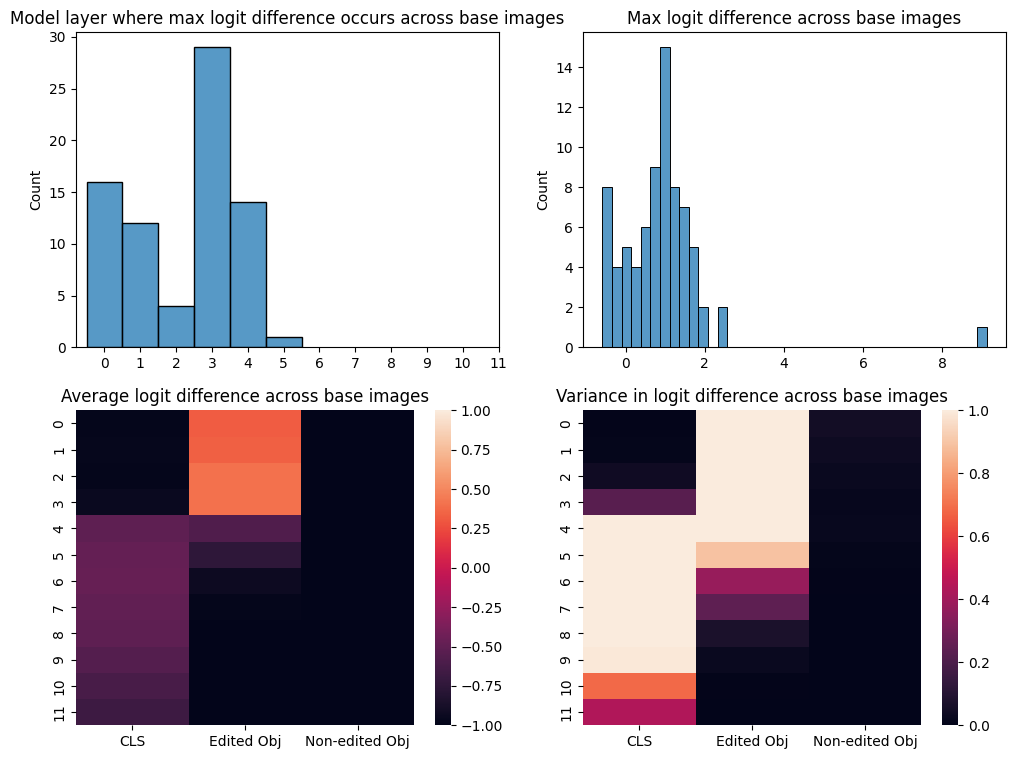

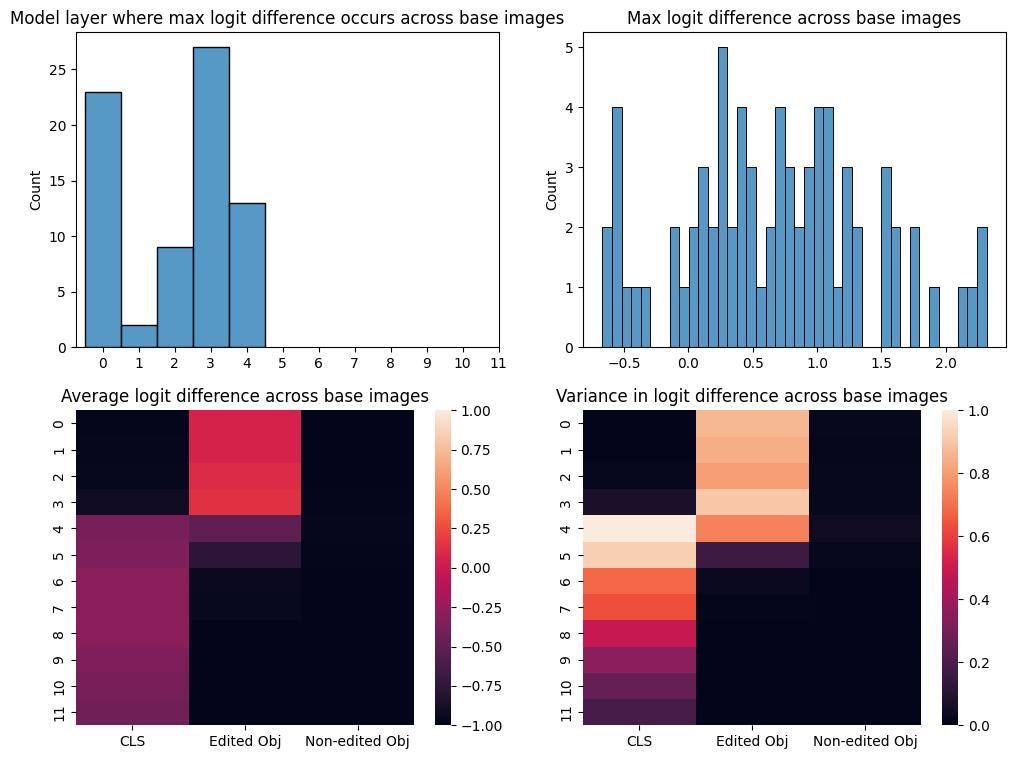

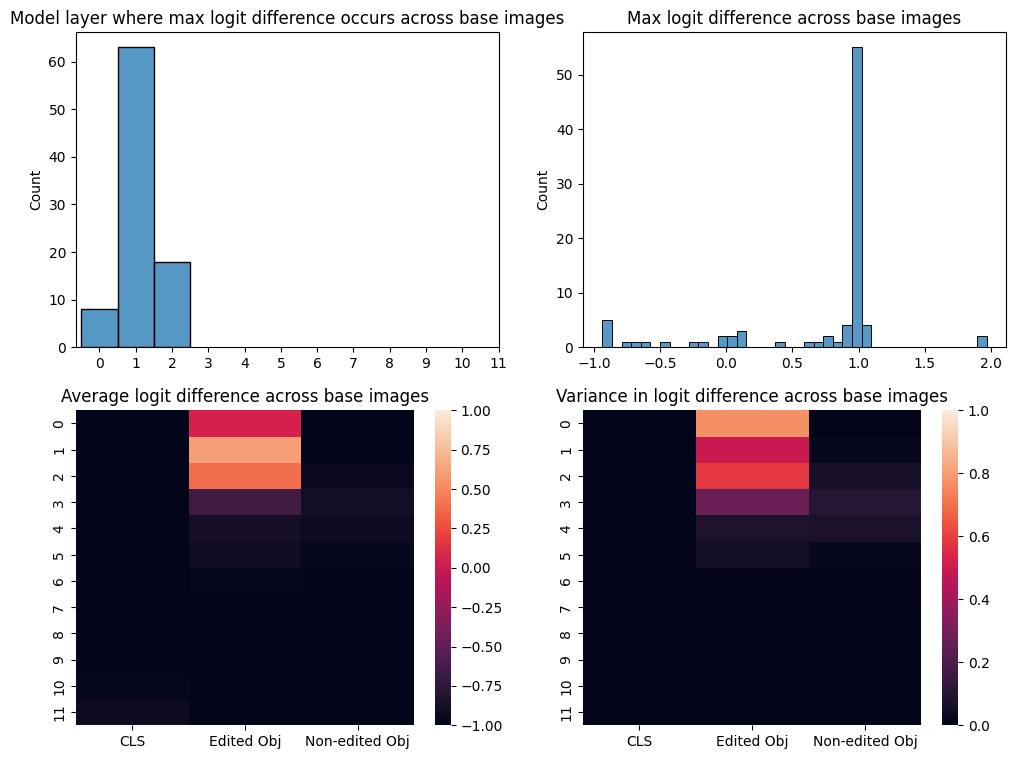

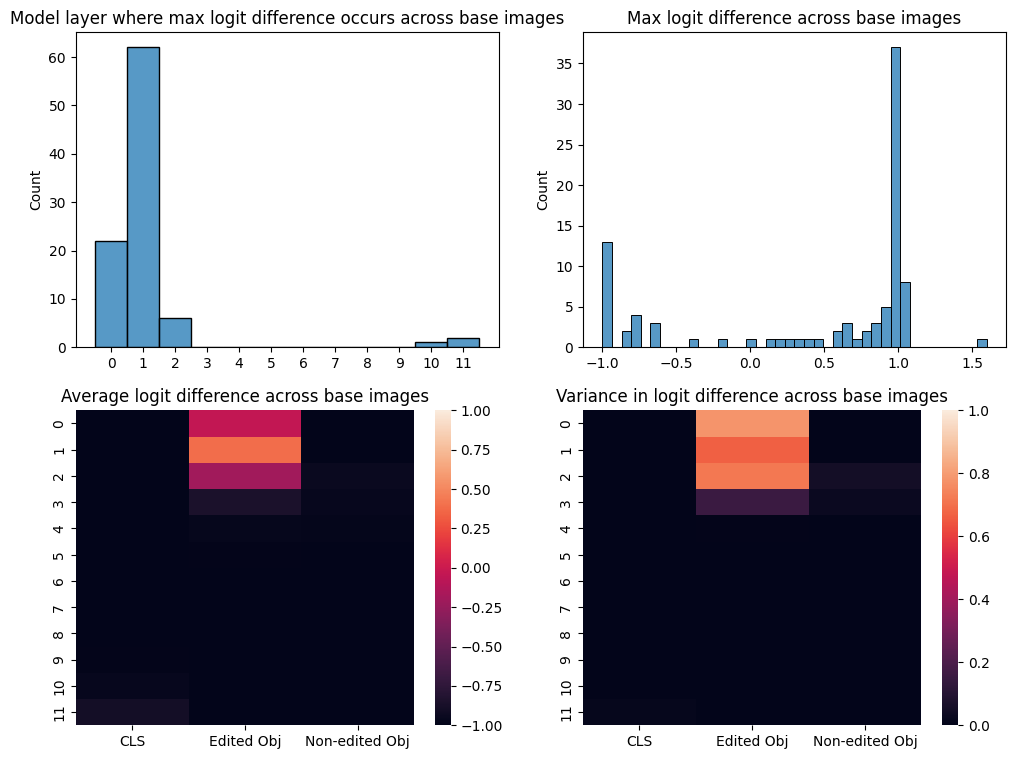

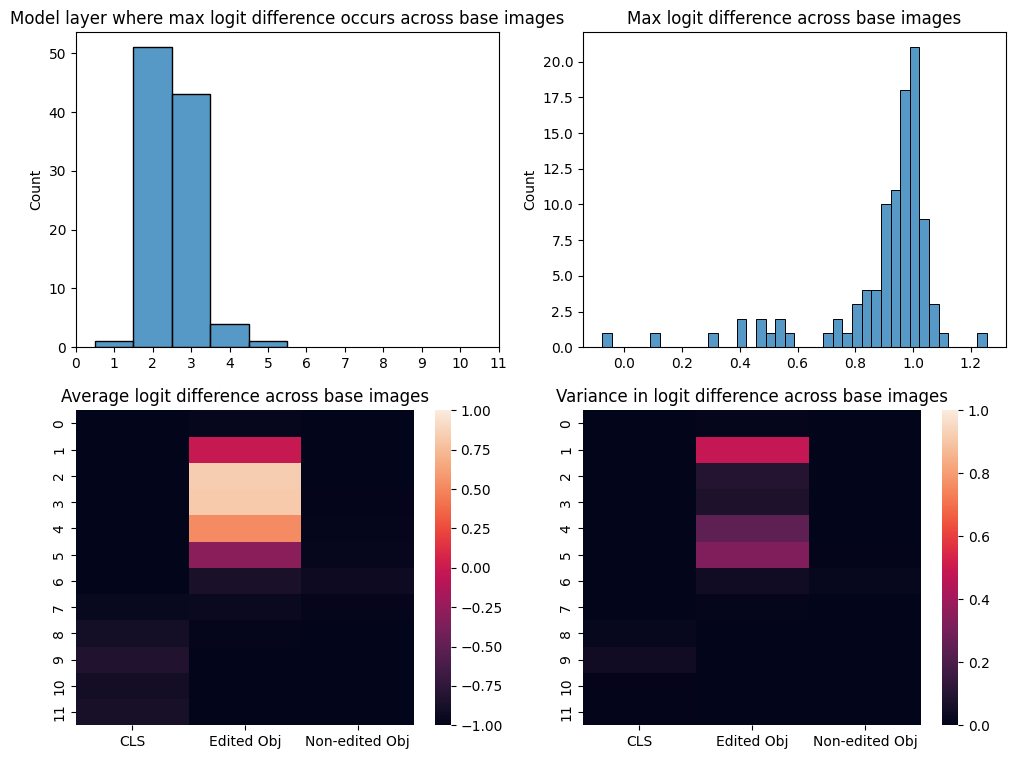

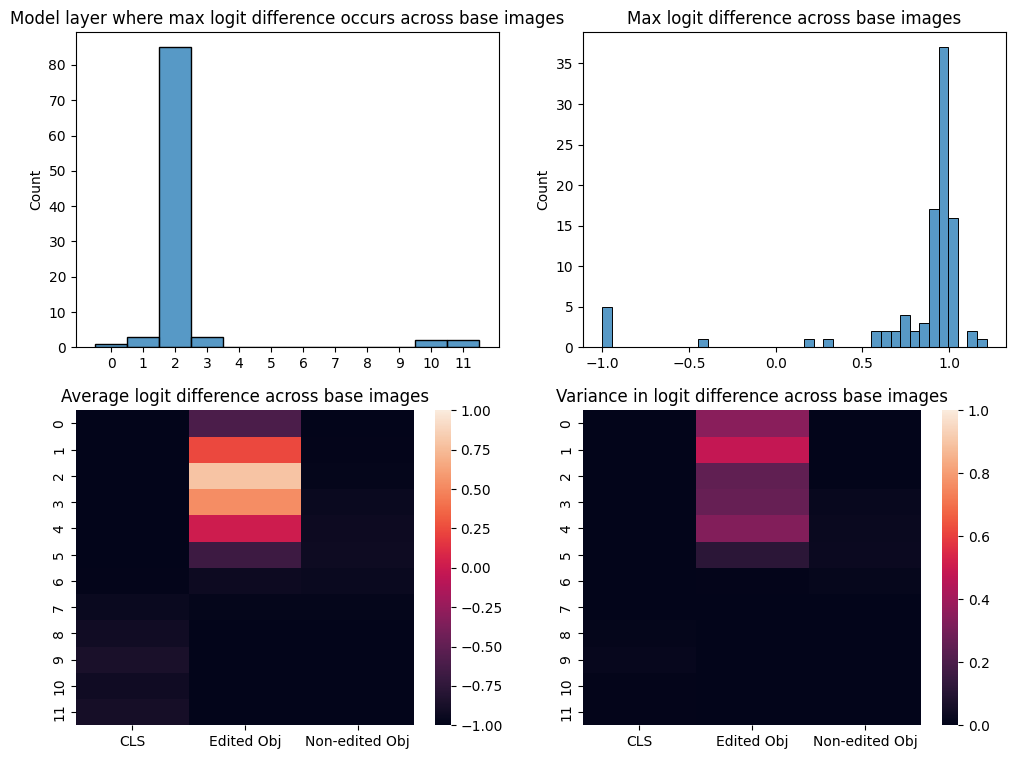

In [253]:
for model in ["scratch", "imagenet", "clip"]:
    for analysis in ["shape", "texture"]:
        subspace_score(pretrain=model, n=100, mode=analysis)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 395.83it/s]


CLIP-Pretrained ViT-B/32 subspace score: 0.804276704788208 (variance=0.22334710229055582)


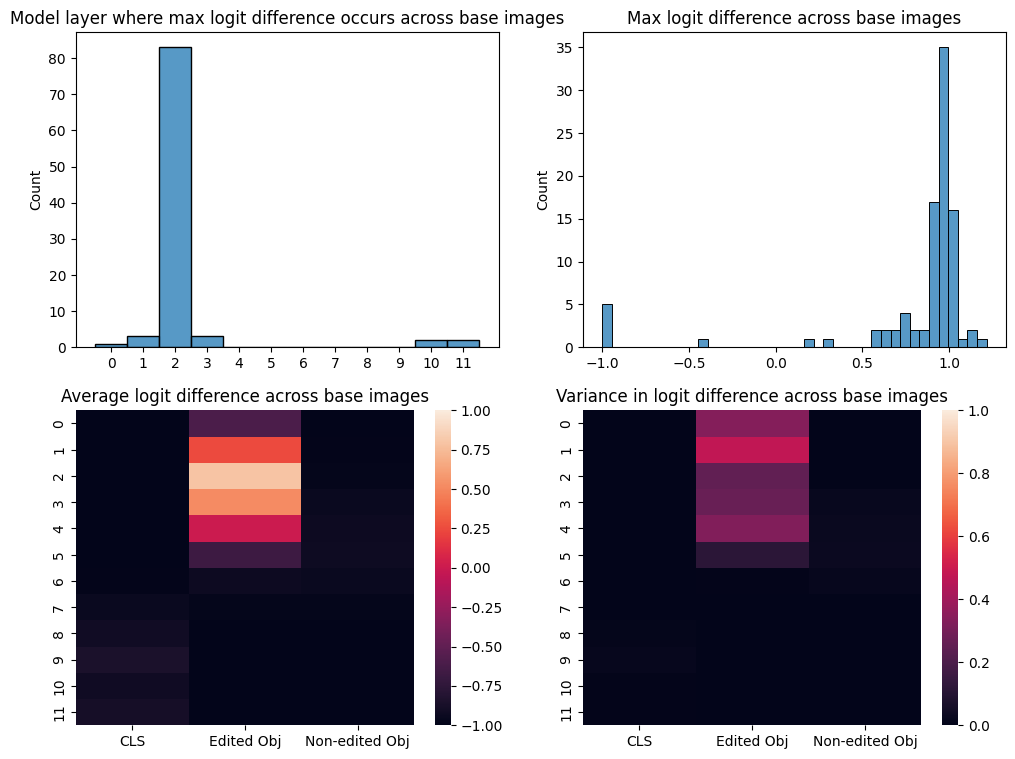

In [265]:
subspace_score(pretrain="clip", sets="all", mode="texture")

# Adversarial shape/texture vectors

In [162]:
def vector_derivative(model, base, same_feat_vecs, base_logits_diff, same_logits_diff, vec, criterion=None, layer=0, tok=0):
    '''Computes the gradient on an intervention vector to change model decision.'''
    
    def patch_fn(
        target_residual_component: Float[torch.Tensor, "batch tok d_model"],
        hook,
        tok,
        same_vec,
        diff_vec,
    ):
        target_residual_component[:, tok, :] += same_vec
        target_residual_component[:, tok, :] -= diff_vec
        return target_residual_component
    
    # Turn on grad
    vec.requires_grad = True
    vec.retain_grad()

    #diff_vec = torch.sub(same_feat_vecs[layer, tok], vec)
    
    hook_fn = partial(patch_fn, tok=tok, same_vec=same_feat_vecs[layer, tok], diff_vec=vec)
    
    if not criterion:
        criterion = torch.nn.CrossEntropyLoss()
    
    with torch.set_grad_enabled(True):
        '''
        # Set existing grad to zero
        model.model.zero_grad()
        
        # Pass image through
        out = model.model(im)
        
        # Get normalized attention scores & compute target
        #attn1 = model.model.blocks[block].attn.attn_scores[0, head, source_tok, :]
        #attn2 = model.model.blocks[block].attn.attn_scores[0, head, dest_tok, :]
        #attn = attn1 + attn2
        if isinstance(head, int):
            attn = model.model.blocks[block].attn.attn_scores[0, head, source_tok, :]
        else:
            attn = model.model.blocks[block].attn.attn_scores[0, :, source_tok, :]
            attn = torch.mean(attn, dim=0)
            
        targ = torch.zeros(attn.shape, requires_grad=True).to("mps")
        targ.data[dest_tok] = 1
        #targ.data[source_tok] = 1
        
        # Compute loss between attention score & target & compute gradients
        loss = criterion(attn, targ)
        loss.backward()
        
        # Retrieve gradient for image
        im_grad = im.grad.data
        return im_grad, loss.item(), attn
        '''
        model.zero_grad()
        
        patched_logits = model.run_with_hooks(
            base,
            fwd_hooks=[(utils.get_act_name("resid_post", layer), hook_fn)],
            return_type="logits",
        )
        patched_logits_diff = patched_logits[0, 1] - patched_logits[0, 0]
        patched_logits_diff = 2*(patched_logits_diff - base_logits_diff) / (same_logits_diff - base_logits_diff) - 1
        
        loss = (1 - patched_logits_diff)**2
        loss.backward()
        vec_grad = vec.grad.data
        
        return vec_grad, loss.item()
    
def run_adversarial_exp(set_idx, pretrain="imagenet", mode="texture", patch_size=32, device="mps", restricted=True, 
                        eta=0.1, steps=50):
    def preprocess(im):
        if pretrain == "clip":
            return image_processor(images=im, return_tensors='pt')["pixel_values"].to(device)
        else:
            return image_processor.preprocess(im, return_tensors="pt")["pixel_values"].to(device)
    
    num_tokens = (224 // patch_size)**2 + 1
    
    image_processor, model = load_model(pretrain=pretrain, patch_size=patch_size)
    
    set_dir = f"stimuli/subspace/{mode}_{patch_size}/base_different/set_{set_idx}"
    base = preprocess(np.array(Image.open(os.path.join(set_dir, "base.png"))))
    same = preprocess(np.array(Image.open(os.path.join(set_dir, "same.png"))))

    base_logits, base_cache = model.run_with_cache(base, remove_batch_dim=True)
    if base_logits[0, 0] < base_logits[0, 1]:
        return

    same_logits, same_cache = model.run_with_cache(same, remove_batch_dim=True)
    if same_logits[0, 0] > same_logits[0, 1]:
        return
    
    base_logits_diff = base_logits[0, 1] - base_logits[0, 0]
    same_logits_diff = same_logits[0, 1] - same_logits[0, 0]
    
    # Images containing the original two different textures/shapes
    base_feat = [np.array(Image.open(b), dtype=np.float32) for b in glob.glob(f"{set_dir}/{mode}0_*.png")]   
    base_feat = preprocess(base_feat)
    
    # Images containing the same two textures
    same_feat = [np.array(Image.open(s), dtype=np.float32) for s in glob.glob(f"{set_dir}/{mode}1_*.png")]
    same_feat = preprocess(same_feat)
    
    def get_mean_cache(ims):
        mean_cache = torch.zeros((model.cfg.n_layers, num_tokens, model.cfg.d_model), device=device)
        _, cache = model.run_with_cache(ims)
        
        for layer in range(model.cfg.n_layers):
            activations = cache[utils.get_act_name("resid_post", layer)]
            mean = torch.mean(activations, dim=0)
            mean_cache[layer, :, :] = mean
        
        return mean_cache
    
    same_feat_vecs = get_mean_cache(same_feat)
    base_feat_vecs = get_mean_cache(base_feat)

    base2same_feat_vecs = same_feat_vecs - base_feat_vecs
    
    def patch_fn(
        target_residual_component: Float[torch.Tensor, "batch tok d_model"],
        hook,
        tok,
        diff_vec,
    ):
        target_residual_component[:, tok, :] += diff_vec
        return target_residual_component
    
    logit_diffs = torch.zeros((model.cfg.n_layers, num_tokens), device=device)
    
    if restricted:
        stim_dict = pickle.load(open(os.path.join(set_dir, "datadict.pkl"), "rb"))
        
        if stim_dict["base.png"]["t1"] != stim_dict["same.png"]["t1"]:  # Which object in the image is the edited one?
            edited_pos = stim_dict["base.png"]["pos1"] + 1
            not_edited_pos = stim_dict["base.png"]["pos2"] + 1
        else:
            edited_pos = stim_dict["base.png"]["pos2"] + 1
            not_edited_pos = stim_dict["base.png"]["pos1"] + 1
        
        iterator = tqdm_itertools.product(range(model.cfg.n_layers), [0, edited_pos, not_edited_pos])
        iterator = tqdm_itertools.product([2], [edited_pos])
        restricted_str = "_restricted"
    else:
        iterator = tqdm_itertools.product(range(model.cfg.n_layers), range(num_tokens))
        restricted_str = ""
    
    optim_vecs = {}
    
    for layer, tok in iterator:
        vec = torch.from_numpy(np.random.normal(size=base2same_feat_vecs[layer, tok].shape).astype(np.float32)).to(device)
        losses = []
        
        for i in range(steps):
            d, loss = vector_derivative(model, base, same_feat_vecs, base_logits_diff, same_logits_diff, vec, layer=layer, tok=tok)
            vec = vec.detach() - (eta * d)
            losses.append(loss)
        
        optim_vecs[f"{layer}-{tok}"] = vec
        break
        
        '''
        hook_fn = partial(patch_fn, tok=tok, diff_vec=base2same_feat_vecs[layer, tok])
        patched_logits = model.run_with_hooks(
            base,
            fwd_hooks=[(utils.get_act_name("resid_post", layer), hook_fn)],
            return_type="logits",
        )
        patched_logits_diff = patched_logits[0, 1] - patched_logits[0, 0]
        logit_diffs[layer, tok] = 2*(patched_logits_diff - base_logits_diff) / (same_logits_diff - base_logits_diff) - 1
        '''

    '''
    torch.save(logit_diffs, f"{set_dir}/logit_diffs_{pretrain}{restricted_str}{distractor_str}{random_str}.pt", 
               pickle_protocol=pickle.HIGHEST_PROTOCOL)
    '''
    print(losses[-1])
    return optim_vecs, losses, base_feat_vecs

'''
def create_max_attn_im(model, im, steps, eta=0.1, head=11, block=3, source_tok=16, dest_tok=23, criterion=None,
                      mask=False):

    x = model.preprocess(im)
    xs = [x]
    losses = []
    attns = []
    
    # Restrict gradient to dest_tok patch
    if mask:
        boolmask = torch.zeros(x.shape).to("mps")
        tok_boolmask(boolmask, dest_tok)
    else:
        boolmask = torch.ones(x.shape).to("mps")

    for i in tqdm.tqdm(range(steps)):
        d, loss, attn = input_derivative(model, x, head=head, block=block, source_tok=source_tok, 
                                         dest_tok=dest_tok, criterion=criterion)

        d = d * boolmask
        
        x = x.detach() - (eta * d)
        #x[boolmask == 1] = torch.where(d[boolmask == 1] > 0, 1.0, 0.0).to("mps")
        #x.requires_grad = True
        #x = torch.clamp(x, min=0)

        xs.append(x)
        losses.append(loss)
        
        if i == 0 or i == steps - 1:
            attns.append(attn)

    return xs, losses, attns
    
#im_grad, loss = input_derivative(model, test_im)
def dist(x, y):
    return torch.sqrt(torch.sum(torch.pow(torch.subtract(torch.flatten(x), torch.flatten(y)), 2), dim=0)) 

ims, losses, attns = create_max_attn_im(model, test_im, 5000, eta=0.01, head="all", source_tok=13, dest_tok=12, mask=True)
'''
optim_vecs, losses, manual_vecs = run_adversarial_exp(349, pretrain="clip", eta=0.1, steps=1000)

If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


  0%|          | 0/1 [00:00<?, ?it/s]

0.01683126389980316


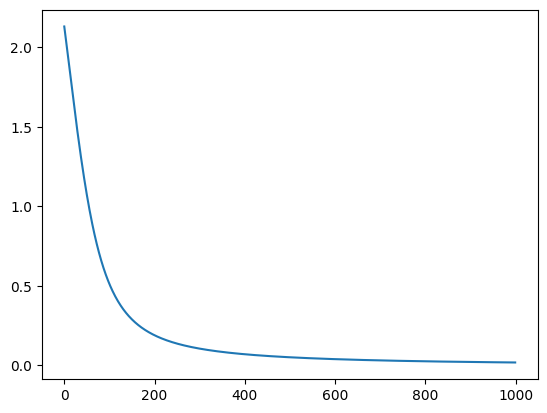

In [163]:
#optim_vecs['0-0'].shape
plt.plot(losses)

In [165]:
vec_adv = optim_vecs['2-12']
vec_manual = manual_vecs[2, 12]
cos = torch.nn.CosineSimilarity(dim=0)
cos(vec_adv, vec_manual)

tensor(-0.0337, device='mps:0')

# Accuracy

In [302]:
def get_accuracy(pretrain="imagenet", mode="texture", patch_size=32):
    try: 
        results = pickle.load(open(f"stimuli/subspace/{mode}_{patch_size}/{pretrain}.pkl", "rb"))
    except FileNotFoundError:
        try:
            if torch.cuda.is_available():
                device = torch.device("cuda")
            elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
                device = torch.device("mps")
            else:
                device = torch.device("cpu")
        except AttributeError:  # if MPS is not available
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

        def preprocess(im):
            if pretrain == "clip":
                return image_processor(images=im, return_tensors='pt')["pixel_values"].to(device)
            else:
                return image_processor.preprocess(im, return_tensors="pt")["pixel_values"].to(device)

        num_tokens = (224 // patch_size)**2 + 1

        torch.set_grad_enabled(False)
        image_processor, model = load_model(pretrain=pretrain, patch_size=patch_size)

        sets = range(3200)
        results = {i: {"acc": 0, "same_acc": 0, "base_acc": 0, "same_logit": 0, "base_logit": 0} for i in sets}

        for set_idx in tqdm.tqdm(sets):
            set_dir = f"stimuli/subspace/{mode}_{patch_size}/base_different/set_{set_idx}"

            base = preprocess(np.array(Image.open(os.path.join(set_dir, "base.png"))))
            same = preprocess(np.array(Image.open(os.path.join(set_dir, "same.png"))))

            base_logit = model(base).squeeze(0)
            same_logit = model(same).squeeze(0)

            results[set_idx]["base_logit"] = base_logit
            results[set_idx]["same_logit"] = same_logit

            if base_logit[0] > base_logit[1]:
                base_acc = True
                results[set_idx]["base_acc"] += 1
            else:
                base_acc = False
                
            if same_logit[1] > same_logit[0]:
                same_acc = True
                results[set_idx]["same_acc"] += 1
            else:
                same_acc = False
                
            if same_acc and base_acc:
                results[set_idx]["acc"] += 1

        with open(f"stimuli/subspace/{mode}_{patch_size}/{pretrain}.pkl", "wb") as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return results

def get_test_accuracy(pretrain="imagenet", mode="texture", patch_size=32, compositional=192):
    try:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
    except AttributeError:  # if MPS is not available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

    def preprocess(im):
        if pretrain == "clip":
            return image_processor(images=im, return_tensors='pt')["pixel_values"].to(device)
        else:
            return image_processor.preprocess(im, return_tensors="pt")["pixel_values"].to(device)

    num_tokens = (224 // patch_size)**2 + 1

    torch.set_grad_enabled(False)
    image_processor, model = load_model(pretrain=pretrain, patch_size=patch_size, compositional=compositional)
    
    diff_imfiles = glob.glob(f"stimuli/NOISE_RGB/aligned/N_32/trainsize_6400_{compositional}-{compositional}-{256-compositional}/test/different/*.png")
    same_imfiles = glob.glob(f"stimuli/NOISE_RGB/aligned/N_32/trainsize_6400_{compositional}-{compositional}-{256-compositional}/test/same/*.png")
    
    diff_ims = torch.zeros((len(diff_imfiles), 3, 224, 224)).to(device)
    same_ims = torch.zeros((len(same_imfiles), 3, 224, 224)).to(device)
    
    for f in range(len(diff_imfiles)):
        diff_ims[f, :, :, :] = preprocess(np.array(Image.open(diff_imfiles[f])))
        
    for f in range(len(same_imfiles)):
        same_ims[f, :, :, :] = preprocess(np.array(Image.open(same_imfiles[f])))   

    diff_logits = model(diff_ims)
    same_logits = model(same_ims)

    diff_acc = sum(diff_logits[:, 0] > diff_logits[:, 1]).item() / len(diff_imfiles)
    same_acc = sum(same_logits[:, 0] < same_logits[:, 1]).item() / len(same_imfiles)
    total_acc = (diff_acc + same_acc) / 2
    
    print(f"{pretrain} compositional model {compositional}-{compositional}-{256-compositional}:")
    print(f"\tTotal accuracy: {total_acc}")
    print(f"\tDifferent accuracy: {diff_acc}")
    print(f"\tSame accuracy: {same_acc}")
    print()
    #return diff_acc, same_acc

In [303]:
for pretrain in ["imagenet", "clip", "scratch"]:
    for compositional in [192, 96, 48, 32]:
        get_test_accuracy(pretrain=pretrain, compositional=compositional)

If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps
imagenet compositional model 192-192-64:
	Total accuracy: 0.985625
	Different accuracy: 0.976875
	Same accuracy: 0.994375



If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps
imagenet compositional model 96-96-160:
	Total accuracy: 0.971875
	Different accuracy: 0.9615625
	Same accuracy: 0.9821875



If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps
imagenet compositional model 48-48-208:
	Total accuracy: 0.9171875
	Different accuracy: 0.9275
	Same accuracy: 0.906875



If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps
imagenet compositional model 32-32-224:
	Total accuracy: 0.94421875
	Different accuracy: 0.9121875
	Same accuracy: 0.97625



If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

clip compositional model 192-192-64:
	Total accuracy: 0.9993749999999999
	Different accuracy: 0.9990625
	Same accuracy: 0.9996875



If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer
clip compositional model 96-96-160:
	Total accuracy: 0.9942187499999999
	Different accuracy: 0.989375
	Same accuracy: 0.9990625



If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer
clip compositional model 48-48-208:
	Total accuracy: 0.98453125
	Different accuracy: 0.969375
	Same accuracy: 0.9996875



If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer
clip compositional model 32-32-224:
	Total accuracy: 0.9840625000000001
	Different accuracy: 0.968125
	Same accuracy: 1.0



If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps
scratch compositional model 192-192-64:
	Total accuracy: 0.91171875
	Different accuracy: 0.879375
	Same accuracy: 0.9440625



If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps
scratch compositional model 96-96-160:
	Total accuracy: 0.8807812500000001
	Different accuracy: 0.8678125
	Same accuracy: 0.89375



If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps
scratch compositional model 48-48-208:
	Total accuracy: 0.88546875
	Different accuracy: 0.8115625
	Same accuracy: 0.959375



If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  mps
scratch compositional model 32-32-224:
	Total accuracy: 0.72921875
	Different accuracy: 0.8128125
	Same accuracy: 0.645625



In [ ]:
acc = 0
same_logit_diff = []
same_same_logit = []
same_diff_logit = []

diff_logit_diff = []
diff_same_logit = []
diff_diff_logit = []

for i in range(3200):
    acc += results[i]["acc"]
    same_logit_diff.append(abs(results[i]["same_logit"][1] - results[i]["same_logit"][0]).item())
    same_same_logit.append(results[i]["same_logit"][1].item())
    same_diff_logit.append(results[i]["same_logit"][0].item())
    
    diff_logit_diff.append(abs(results[i]["base_logit"][1] - results[i]["base_logit"][0]).item())
    diff_same_logit.append(results[i]["base_logit"][1].item())
    diff_diff_logit.append(results[i]["base_logit"][0].item())

print(f"Total accuracy: {(acc/3200)*100}%")
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
sns.histplot(data=same_logit_diff, ax=ax[0], color="#7B42FF")
ax[0].set_title('Logit Difference for "Same" Images')
sns.histplot(data=same_diff_logit, ax=ax[1], color="#FF4242")
ax[1].set_title('"Different" Logit on "Same" Images')
sns.histplot(data=same_same_logit, ax=ax[2], color="#42AFFF")
ax[2].set_title('"Same" Logit on "Same" Images')
plt.tight_layout()

fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
sns.histplot(data=diff_logit_diff, ax=ax[0], color="#7B42FF")
ax[0].set_title('Logit Difference for "Diff" Images')
sns.histplot(data=diff_diff_logit, ax=ax[1], color="#FF4242")
ax[1].set_title('"Different" Logit on "Diff" Images')
sns.histplot(data=diff_same_logit, ax=ax[2], color="#42AFFF")
ax[2].set_title('"Same" Logit on "Diff" Images')
plt.tight_layout()

# Check compositional

In [272]:
# 32, 48, 96, 192
for c in [32]:
    train_data = pickle.load(open(f"stimuli/NOISE_RGB/aligned/N_32/trainsize_6400_{c}-{c}-{256-c}/train/datadict.pkl", "rb"))
    val_data = pickle.load(open(f"stimuli/NOISE_RGB/aligned/N_32/trainsize_6400_{c}-{c}-{256-c}/val/datadict.pkl", "rb"))
    test_data = pickle.load(open(f"stimuli/NOISE_RGB/aligned/N_32/trainsize_6400_{c}-{c}-{256-c}/test/datadict.pkl", "rb"))

    train_combos = []
    val_combos = []
    test_combos = []

    for t, v in train_data.items():
        obj1 = f"{v['s1']}-{v['t1']}"
        obj2 = f"{v['s2']}-{v['t2']}"
        train_combos.append(obj1)
        train_combos.append(obj2)
    train_combos = set(train_combos)    

    for t, v in val_data.items():
        obj1 = f"{v['s1']}-{v['t1']}"
        obj2 = f"{v['s2']}-{v['t2']}"
        val_combos.append(obj1)
        val_combos.append(obj2)
    val_combos = set(val_combos)   

    for t, v in test_data.items():
        obj1 = f"{v['s1']}-{v['t1']}"
        obj2 = f"{v['s2']}-{v['t2']}"
        test_combos.append(obj1)
        test_combos.append(obj2)
    test_combos = set(test_combos)   

    print(f"Compositional set {c}-{c}-{256-c}:")
    print(len(train_combos) == c)
    print(len(val_combos) == c)
    print(len(test_combos) == 256-c)
    print(len(train_combos.intersection(val_combos)) == c)
    print(len(train_combos.intersection(test_combos)) == 0)
    print(len(val_combos.intersection(test_combos)) == 0)
    print()

Compositional set 32-32-224:
True
True
True
True
True
True

